# Libraries

In [126]:
options(warn=-1)
library(dplyr)
library(DataExplorer)
library(ggplot2)
library(tidyr)
library(patchwork)
library(cowplot)
library(scales)
library(tidyverse)

# Introduction

## Problem description

## Data description

In [127]:
adult_data <- read.csv(file="data\\adult.data", stringsAsFactors = TRUE, 
                       col.names=c("age", "workclass", "fnlwgt", "education", 
                                   "education.num","marital.status", "occupation", "relationship", "race","sex",
                                   "capital.gain", "capital.loss", "hours.per.week","native.country", "income"))

In [128]:
head(adult_data)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K


## Data preprocessing

In [129]:
trim_factor_columns <- function(x) {
  if (is.factor(x)) {
    x <- as.factor(trimws(as.character(x)))
  }
  return(x)
}

adult_data <- adult_data %>%
  mutate_if(is.factor, trim_factor_columns)

In [130]:
adult_data <- subset(adult_data, select = -education.num)

## Missing values

In [131]:
sum(complete.cases(adult_data))

[1] 32560

In [132]:
columns_names_with_question <- names(adult_data)[sapply(adult_data, function(col) any(col == "?"))]
columns_names_with_question

[1] "workclass"      "occupation"     "native.country"

In [133]:
for (col_name in columns_names_with_question) {
  adult_data[[col_name]][adult_data[[col_name]] == "?"] <- NA
}

In [134]:
columns_with_na <- colSums(is.na(adult_data)) > 0
columns_with_na

age      workclass         fnlwgt      education marital.status 
         FALSE           TRUE          FALSE          FALSE          FALSE 
    occupation   relationship           race            sex   capital.gain 
          TRUE          FALSE          FALSE          FALSE          FALSE 
  capital.loss hours.per.week native.country         income 
         FALSE          FALSE           TRUE          FALSE

In [135]:
sum(complete.cases(adult_data))

[1] 30161

In [136]:
sum(is.na(adult_data))
#some of them are for the same observation

[1] 4262

In [137]:
rows_with_na <- which(!complete.cases(adult_data))
head(adult_data[rows_with_na, c('workclass', 'occupation', 'native.country')], n=10)

,workclass,occupation,native.country
,<fct>,<fct>,<fct>
14,Private,Craft-repair,NA
27,NA,NA,South
38,Private,Sales,NA
51,Private,Other-service,NA
61,NA,NA,NA
69,NA,NA,United-States
77,NA,NA,United-States
93,Private,Sales,NA
106,NA,NA,United-States


In [138]:
sum(is.na(adult_data$workclass))
sum(is.na(adult_data$occupation))
sum(is.na(adult_data$native.country))

[1] 1836

[1] 1843

[1] 583

In [139]:
1836+1843+583

[1] 4262

In [140]:
missing_occupation <- round(sum(is.na(adult_data$occupation))/length(adult_data$occupation) * 100, 2)
missing_workclass <- round(sum(is.na(adult_data$workclass))/length(adult_data$workclass) * 100, 2)
missing_country <- round(sum(is.na(adult_data$native.country))/length(adult_data$native.country) * 100, 2)

occupation_data <- data.frame(Label = c("Missing", "Non-Missing"),
                           Value = c(missing_occupation, 100 - missing_occupation))
workclass_data <- data.frame(Label = c("Missing", "Non-Missing"),
                           Value = c(missing_workclass, 100 - missing_workclass)) 
country_data <- data.frame(Label = c("Missing", "Non-Missing"),
                           Value = c(missing_country, 100 - missing_country))

In [141]:
create_pie_chart <- function(df, title) {
    ggplot(df, aes(x="", y= Value, fill=Label)) +
    geom_bar(stat='identity') +
    coord_polar('y')+
    labs(title=title, fill="") +
    theme_void() +
    scale_fill_manual(values = c("Missing" = "salmon", "Non-Missing" = "skyblue")) +
    geom_text(aes(label = paste0(Value, "%")), position = position_stack(vjust = 0.5), size = 6) +
    theme(legend.position = c(0.15, 0.15),
          plot.title = element_text(hjust = 0.5, size=20),
          legend.text = element_text(size = 14))
}

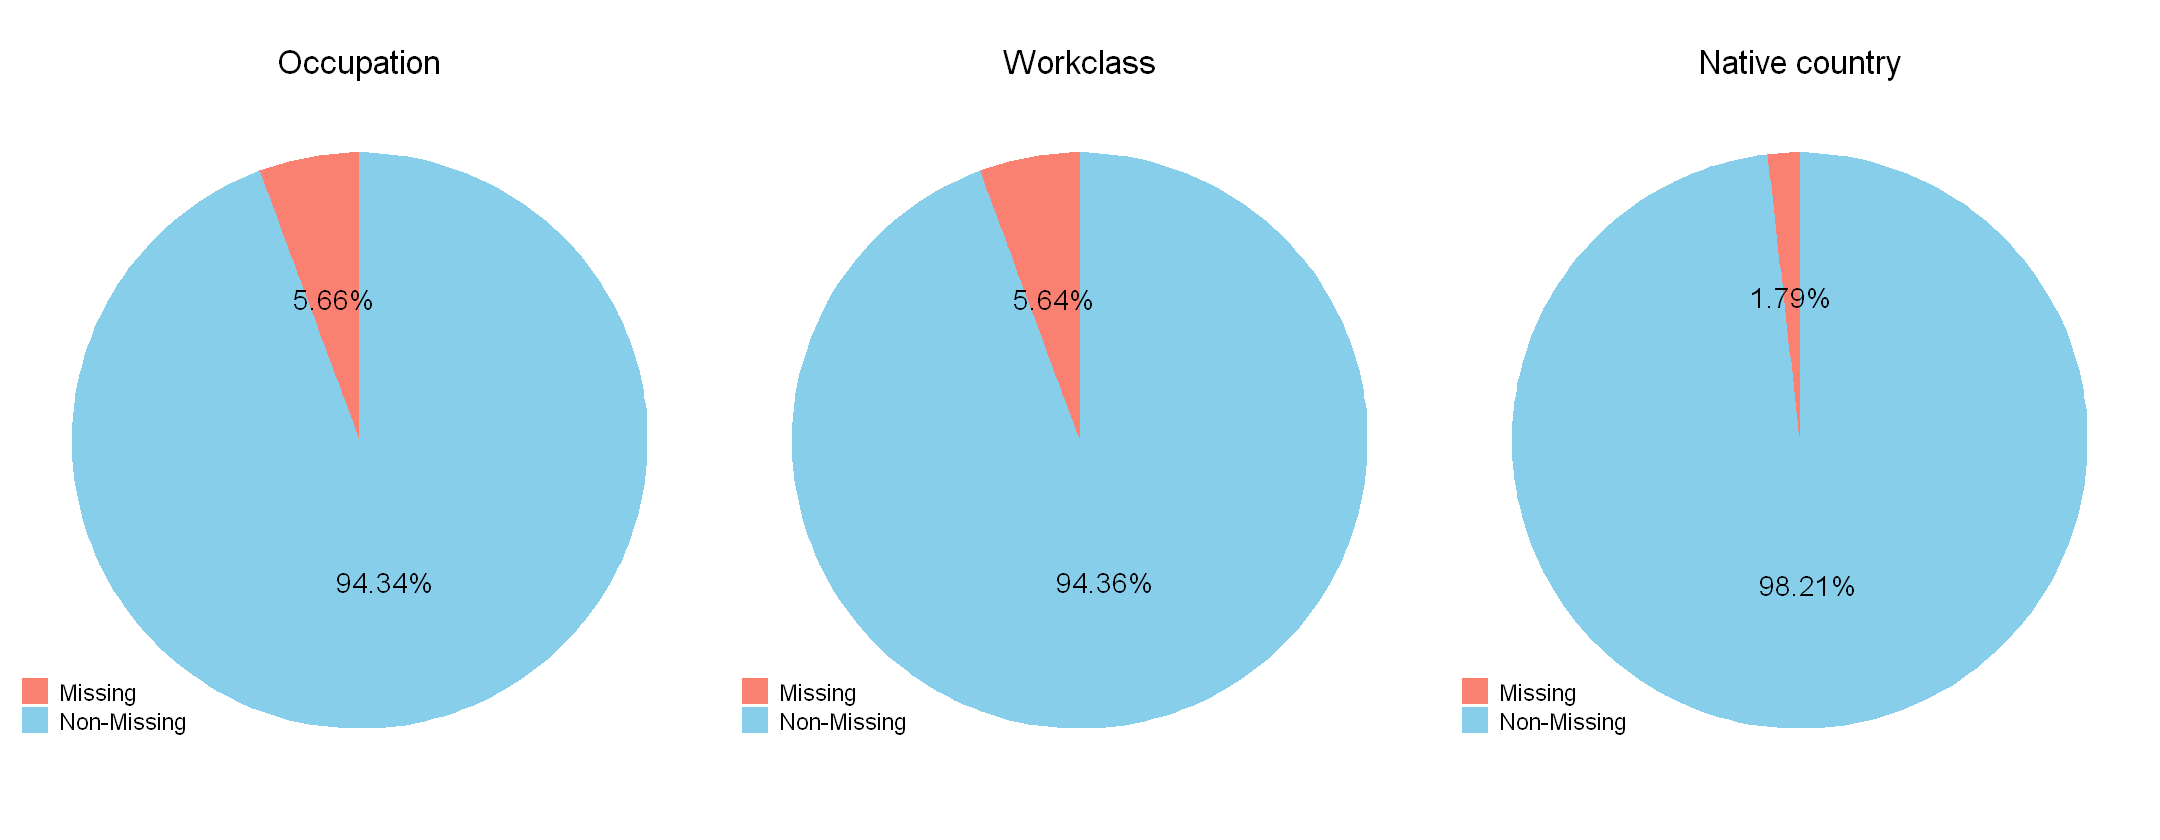

In [142]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
  create_pie_chart(occupation_data, "Occupation"),
  create_pie_chart(workclass_data, "Workclass"),
  create_pie_chart(country_data, "Native country"),
  nrow = 1
)

Let's get rid of rows with missing values and see what happens. 

In [143]:
clean_df <- na.omit(adult_data)
clean_df <- droplevels(clean_df)

Check if some levels disaapeared or if sumarries of numerical columns significantly different. Check in percentages how many observations in each level went off. 

In [250]:
calculate_percentage_changes <- function(column_name) {
  summary_original <- table(adult_data[[column_name]])
  
  summary_clean <- table(clean_df[[column_name]])
  
  all_levels <- unique(c(names(summary_original), names(summary_clean)))
  
  df_original <- data.frame(level = names(summary_original), 
                            original_freq = as.numeric(summary_original) / sum(summary_original) * 100)
  df_clean <- data.frame(level = names(summary_clean), 
                         clean_freq = as.numeric(summary_clean) / sum(summary_clean) * 100)
  
  merged_df <- merge(df_original, df_clean, by = "level", all = TRUE)
  summary_original <- summary_original[all_levels]
  summary_clean <- summary_clean[all_levels]
  decrease <- summary_original - summary_clean
  percentage_decrease <- (decrease / summary_original) * 100  
  merged_df$percentage_decrease <- with(merged_df, percentage_decrease)
  
  return(merged_df)
}

In [251]:
summary(adult_data$age)
summary(clean_df$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.58   48.00   90.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.44   47.00   90.00 

In [252]:
summary(adult_data$workclass)
summary(clean_df$workclass)
as.data.frame(calculate_percentage_changes("workclass"))

?      Federal-gov        Local-gov     Never-worked 
               0              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1297 
     Without-pay             NA's 
              14             1836

Federal-gov        Local-gov          Private     Self-emp-inc 
             943             2067            22286             1074 
Self-emp-not-inc        State-gov      Without-pay 
            2499             1278               14

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
?,0.00000000,NA,NA
Federal-gov,3.12459315,3.12655416,1.770833
Local-gov,6.81226403,6.85322105,1.242236
Never-worked,0.02278349,NA,NA
Private,73.87058977,73.89012301,1.806486
Self-emp-inc,3.63233954,3.56088989,3.763441
Self-emp-not-inc,8.27040750,8.28553430,1.652893
State-gov,4.22145554,4.23726004,1.464919
Without-pay,0.04556698,0.04641756,0.000000


In [107]:
summary(adult_data$fnlwgt)
summary(clean_df$fnlwgt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12285  117832  178363  189782  237055 1484705 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13769  117628  178429  189798  237630 1484705 

In [253]:
summary(adult_data$education)
summary(clean_df$education)
as.data.frame(calculate_percentage_changes("education"))

10th         11th         12th      1st-4th      5th-6th      7th-8th 
         933         1175          433          168          333          646 
         9th   Assoc-acdm    Assoc-voc    Bachelors    Doctorate      HS-grad 
         514         1067         1382         5354          413        10501 
     Masters    Preschool  Prof-school Some-college 
        1723           51          576         7291

10th         11th         12th      1st-4th      5th-6th      7th-8th 
         820         1048          377          151          288          557 
         9th   Assoc-acdm    Assoc-voc    Bachelors    Doctorate      HS-grad 
         455         1008         1307         5043          375         9840 
     Masters    Preschool  Prof-school Some-college 
        1627           45          542         6678

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
10th,2.8654791,2.7187427,12.111468
11th,3.6087224,3.4746859,10.808511
12th,1.3298526,1.2499586,12.933025
1st-4th,0.5159705,0.5006465,10.119048
5th-6th,1.0227273,0.9548755,13.513514
7th-8th,1.9840295,1.8467557,13.777090
9th,1.5786241,1.5085707,11.478599
Assoc-acdm,3.2770270,3.3420643,5.529522
Assoc-voc,4.2444717,4.3334107,5.426918


In [254]:
summary(adult_data$marital.status)
summary(clean_df$marital.status)
as.data.frame(calculate_percentage_changes("marital.status"))

Divorced     Married-AF-spouse    Married-civ-spouse 
                 4443                    23                 14976 
Married-spouse-absent         Never-married             Separated 
                  418                 10682                  1025 
              Widowed 
                  993

Divorced     Married-AF-spouse    Married-civ-spouse 
                 4214                    21                 14065 
Married-spouse-absent         Never-married             Separated 
                  370                  9725                   939 
              Widowed 
                  827

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Divorced,13.64557740,13.97168529,5.154175
Married-AF-spouse,0.07063882,0.06962634,8.695652
Married-civ-spouse,45.99508600,46.63306920,6.083066
Married-spouse-absent,1.28378378,1.22674978,11.483254
Never-married,32.80712531,32.24362587,8.958996
Separated,3.14803440,3.11329200,8.390244
Widowed,3.04975430,2.74195153,16.717019


In [255]:
summary(adult_data$occupation)
summary(clean_df$occupation)
as.data.frame(calculate_percentage_changes("occupation"))

?      Adm-clerical      Armed-Forces      Craft-repair 
                0              3769                 9              4099 
  Exec-managerial   Farming-fishing Handlers-cleaners Machine-op-inspct 
             4066               994              1370              2002 
    Other-service   Priv-house-serv    Prof-specialty   Protective-serv 
             3295               149              4140               649 
            Sales      Tech-support  Transport-moving              NA's 
             3650               928              1597              1843

Adm-clerical      Armed-Forces      Craft-repair   Exec-managerial 
             3720                 9              4030              3992 
  Farming-fishing Handlers-cleaners Machine-op-inspct     Other-service 
              989              1350              1966              3212 
  Priv-house-serv    Prof-specialty   Protective-serv             Sales 
              143              4038               644              3584 
     Tech-support  Transport-moving 
              912              1572

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
?,0.00000000,NA,NA
Adm-clerical,12.27007846,12.33380856,1.3000796
Armed-Forces,0.02929974,0.02983986,0.0000000
Craft-repair,13.34440212,13.36162594,1.6833374
Exec-managerial,13.23696976,13.23563542,1.8199705
Farming-fishing,3.23599310,3.27906900,0.5030181
Handlers-cleaners,4.46007097,4.47597891,1.4598540
Machine-op-inspct,6.51756356,6.51835151,1.7982018
Other-service,10.72695901,10.64951427,2.5189681


In [256]:
summary(adult_data$relationship)
summary(clean_df$relationship)
as.data.frame(calculate_percentage_changes("relationship"))

Husband  Not-in-family Other-relative      Own-child      Unmarried 
         13193           8304            981           5068           3446 
          Wife 
          1568

Husband  Not-in-family Other-relative      Own-child      Unmarried 
         12463           7725            889           4466           3212 
          Wife 
          1406

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Husband,40.519042,41.321574,5.533237
Not-in-family,25.503686,25.612546,6.972543
Other-relative,3.012899,2.947515,9.378186
Own-child,15.565111,14.807201,11.878453
Unmarried,10.583538,10.649514,6.790482
Wife,4.815725,4.661649,10.331633


In [257]:
summary(adult_data$race)
summary(clean_df$race)
as.data.frame(calculate_percentage_changes("race"))

Amer-Indian-Eskimo Asian-Pac-Islander              Black              Other 
               311               1039               3124                271 
             White 
             27815

Amer-Indian-Eskimo Asian-Pac-Islander              Black              Other 
               286                895               2817                231 
             White 
             25932

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Amer-Indian-Eskimo,0.9551597,0.9482444,8.038585
Asian-Pac-Islander,3.1910319,2.9674082,13.859480
Black,9.5945946,9.3398760,9.827145
Other,0.8323096,0.7658897,14.760148
White,85.4269042,85.9785816,6.769729


In [258]:
summary(adult_data$sex)
summary(clean_df$sex)
as.data.frame(calculate_percentage_changes("sex"))

Female   Male 
 10771  21789

Female   Male 
  9782  20379

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
Female,33.08047,32.43261,9.182063
Male,66.91953,67.56739,6.471155


In [260]:
summary(adult_data$capital.gain)
summary(clean_df$capital.gain)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    1078       0   99999 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    1092       0   99999 

In [117]:
summary(adult_data$capital.loss)
summary(clean_df$capital.loss)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   87.31    0.00 4356.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   88.38    0.00 4356.00 

In [118]:
summary(adult_data$hours.per.week)
summary(clean_df$hours.per.week)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   40.00   40.00   40.44   45.00   99.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   40.00   40.00   40.93   45.00   99.00 

In [261]:
summary(adult_data$native.country)
summary(clean_df$native.country)
as.data.frame(calculate_percentage_changes("native.country"))

?                   Cambodia 
                         0                         19 
                    Canada                      China 
                       121                         75 
                  Columbia                       Cuba 
                        59                         95 
        Dominican-Republic                    Ecuador 
                        70                         28 
               El-Salvador                    England 
                       106                         90 
                    France                    Germany 
                        29                        137 
                    Greece                  Guatemala 
                        29                         64 
                     Haiti         Holand-Netherlands 
                        44                          1 
                  Honduras                       Hong 
                        13                         20 
                   Hungary                      India 
                        13                        100 
                      Iran                    Ireland 
                        43                         24 
                     Italy                    Jamaica 
                        73                         81 
                     Japan                       Laos 
                        62                         18 
                    Mexico                  Nicaragua 
                       643                         34 
Outlying-US(Guam-USVI-etc)                       Peru 
                        14                         31 
               Philippines                     Poland 
                       198                         60 
                  Portugal                Puerto-Rico 
                        37                        114 
                  Scotland                      South 
                        12                         80 
                    Taiwan                   Thailand 
                        51                         18 
           Trinadad&Tobago              United-States 
                        19                      29169 
                   Vietnam                 Yugoslavia 
                        67                         16 
                      NA's 
                       583

Cambodia                     Canada 
                        18                        107 
                     China                   Columbia 
                        68                         56 
                      Cuba         Dominican-Republic 
                        92                         67 
                   Ecuador                El-Salvador 
                        27                        100 
                   England                     France 
                        86                         27 
                   Germany                     Greece 
                       128                         29 
                 Guatemala                      Haiti 
                        63                         42 
        Holand-Netherlands                   Honduras 
                         1                         12 
                      Hong                    Hungary 
                        19                         13 
                     India                       Iran 
                       100                         42 
                   Ireland                      Italy 
                        24                         68 
                   Jamaica                      Japan 
                        80                         59 
                      Laos                     Mexico 
                        17                        610 
                 Nicaragua Outlying-US(Guam-USVI-etc) 
                        33                         14 
                      Peru                Philippines 
                        30                        188 
                    Poland                   Portugal 
                        56                         34 
               Puerto-Rico                   Scotland 
                       109                         11 
                     South                     Taiwan 
                        71                         42 
                  Thailand            Trinadad&Tobago 
                        17                         18 
             United-States                    Vietnam 
                     27503                         64 
                Yugoslavia 
                        16

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
?,0.000000000,NA,NA
Cambodia,0.059417706,0.05967972,5.263158
Canada,0.378396973,0.35476277,11.570248
China,0.234543578,0.22545672,9.333333
Columbia,0.184507615,0.18567024,5.084746
Cuba,0.297088532,0.30502967,3.157895
Dominican-Republic,0.218907340,0.22214118,4.285714
Ecuador,0.087562936,0.08951958,3.571429
El-Salvador,0.331488257,0.33155399,5.660377


In [262]:
summary(adult_data$income)
summary(clean_df$income)
as.data.frame(calculate_percentage_changes("income"))

<=50K  >50K 
24719  7841

<=50K  >50K 
22653  7508

level,original_freq,clean_freq,percentage_decrease
<chr>,<dbl>,<dbl>,<table[1d]>
<=50K,75.9183,75.10693,8.357943
>50K,24.0817,24.89307,4.246907


And now check the contigency tables before and after cleaning.

In [146]:
cont_table <- function(df, column) {
  result <- df %>%
    group_by({{column}}, income, .drop = FALSE) %>%
    summarise(count = n(), .groups = "drop_last") %>%
    ungroup() %>%
    pivot_wider(names_from = {{column}}, values_from = count, values_fill = 0)
  return(result)
}

In [149]:
cont_table(adult_data, workclass)
cont_table(clean_df, workclass)

income,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,589,1476,7,17733,494,1817,944,14,1645
>50K,0,371,617,0,4963,622,724,353,0,191


income,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,578,1458,17410,474,1785,934,14
>50K,365,609,4876,600,714,344,0


In [150]:
cont_table(adult_data, education)
cont_table(clean_df, education)

income,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,871,1115,400,162,317,606,487,802,1021,3133,107,8826,764,51,153,5904
>50K,62,60,33,6,16,40,27,265,361,2221,306,1675,959,0,423,1387


income,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,761,989,348,145,276,522,430,752,963,2917,95,8223,709,45,136,5342
>50K,59,59,29,6,12,35,25,256,344,2126,280,1617,918,0,406,1336


In [151]:
cont_table(adult_data, marital.status)
cont_table(clean_df, marital.status)

income,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3980,13,8284,384,10191,959,908
>50K,463,10,6692,34,491,66,85


income,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3762,11,7666,339,9255,873,747
>50K,452,10,6399,31,470,66,80


In [152]:
cont_table(adult_data, occupation)
cont_table(clean_df, occupation)

income,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,3262,8,3170,2098,879,1284,1752,3158,148,2281,438,2667,645,1277,1652
>50K,0,507,1,929,1968,115,86,250,137,1,1859,211,983,283,320,191


income,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3222,8,3122,2055,874,1267,1721,3080,142,2227,434,2614,634,1253
>50K,498,1,908,1937,115,83,245,132,1,1811,210,970,278,319


In [153]:
cont_table(adult_data, relationship)
cont_table(clean_df, relationship)

income,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,7275,7448,944,5001,3228,823
>50K,5918,856,37,67,218,745


income,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,6784,6902,854,4402,2999,712
>50K,5679,823,35,64,213,694


In [ ]:
cont_table(adult_data, race)
cont_table(clean_df, race)

In [154]:
cont_table(adult_data,sex)
cont_table(clean_df, sex)

income,Female,Male
<fct>,<int>,<int>
<=50K,9592,15127
>50K,1179,6662


income,Female,Male
<fct>,<int>,<int>
<=50K,8670,13983
>50K,1112,6396


In [156]:
cont_table(adult_data, native.country)
cont_table(clean_df,  native.country)

income,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,⋯,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,12,82,55,57,70,68,24,97,⋯,102,9,64,31,15,17,21998,62,10,437
>50K,0,7,39,20,2,25,2,4,9,⋯,12,3,16,20,3,2,7171,5,6,146


income,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,⋯,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,11,71,48,54,67,65,23,91,56,⋯,30,97,9,57,23,14,16,20508,59,10
>50K,7,36,20,2,25,2,4,9,30,⋯,4,12,2,14,19,3,2,6995,5,6


# Descriptive analysis and data visualization

## Basic characteristics

In [159]:
str(adult_data)

'data.frame':	32560 obs. of  15 variables:
 $ age           : int  50 38 53 28 37 49 52 31 42 37 ...
 $ workclass     : Factor w/ 9 levels "?","Federal-gov",..: 7 5 5 5 5 5 7 5 5 5 ...
 $ fnlwgt        : int  83311 215646 234721 338409 284582 160187 209642 45781 159449 280464 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 10 12 2 10 13 7 12 13 10 16 ...
 $ marital.status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 3 1 3 3 3 4 3 5 3 3 ...
 $ occupation    : Factor w/ 15 levels "?","Adm-clerical",..: 5 7 7 11 5 9 5 11 5 5 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 1 2 1 6 6 2 1 2 1 1 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 3 3 5 3 5 5 5 3 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 1 1 1 2 1 2 2 ...
 $ capital.gain  : int  0 0 0 0 0 0 0 14084 5178 0 ...
 $ capital.loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours.per.week: int  13 40 40 40 40 16 45 50 40 80 ...
 $ native.country: Factor 

In [160]:
num_unique_values <- sapply(adult_data, function(x) length(unique(x)))

for (i in 1:length(num_unique_values)) {
  print(paste0(names(num_unique_values)[i], ": ", num_unique_values[i]))
}

[1] "age: 73"
[1] "workclass: 9"
[1] "fnlwgt: 21647"
[1] "education: 16"
[1] "marital.status: 7"
[1] "occupation: 15"
[1] "relationship: 6"
[1] "race: 5"
[1] "sex: 2"
[1] "capital.gain: 119"
[1] "capital.loss: 92"
[1] "hours.per.week: 94"
[1] "native.country: 42"
[1] "income: 2"
[1] "age_group: 8"


In [161]:
numerical_columns <- names(adult_data[sapply(adult_data, is.numeric)])
factor_columns <- names(adult_data[sapply(adult_data, is.factor)])

In [162]:
#summary(adult_data[factor_columns])

In [163]:
#summary(adult_data[numerical_columns])

## Exploratory data analysis

### Whole data set

#### Bar plots

In [164]:
bar_plots <- lapply(factor_columns, function(column) {
    ggplot(adult_data, aes_string(x = column)) +
    geom_bar(fill='skyblue') +
    labs(title = column) +
    scale_y_continuous(breaks = pretty_breaks(n = 6)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=12),
          axis.text.y = element_text(size=14),
          axis.title.x = element_blank(),
          plot.title = element_text(hjust = 0.5, size=20))
})

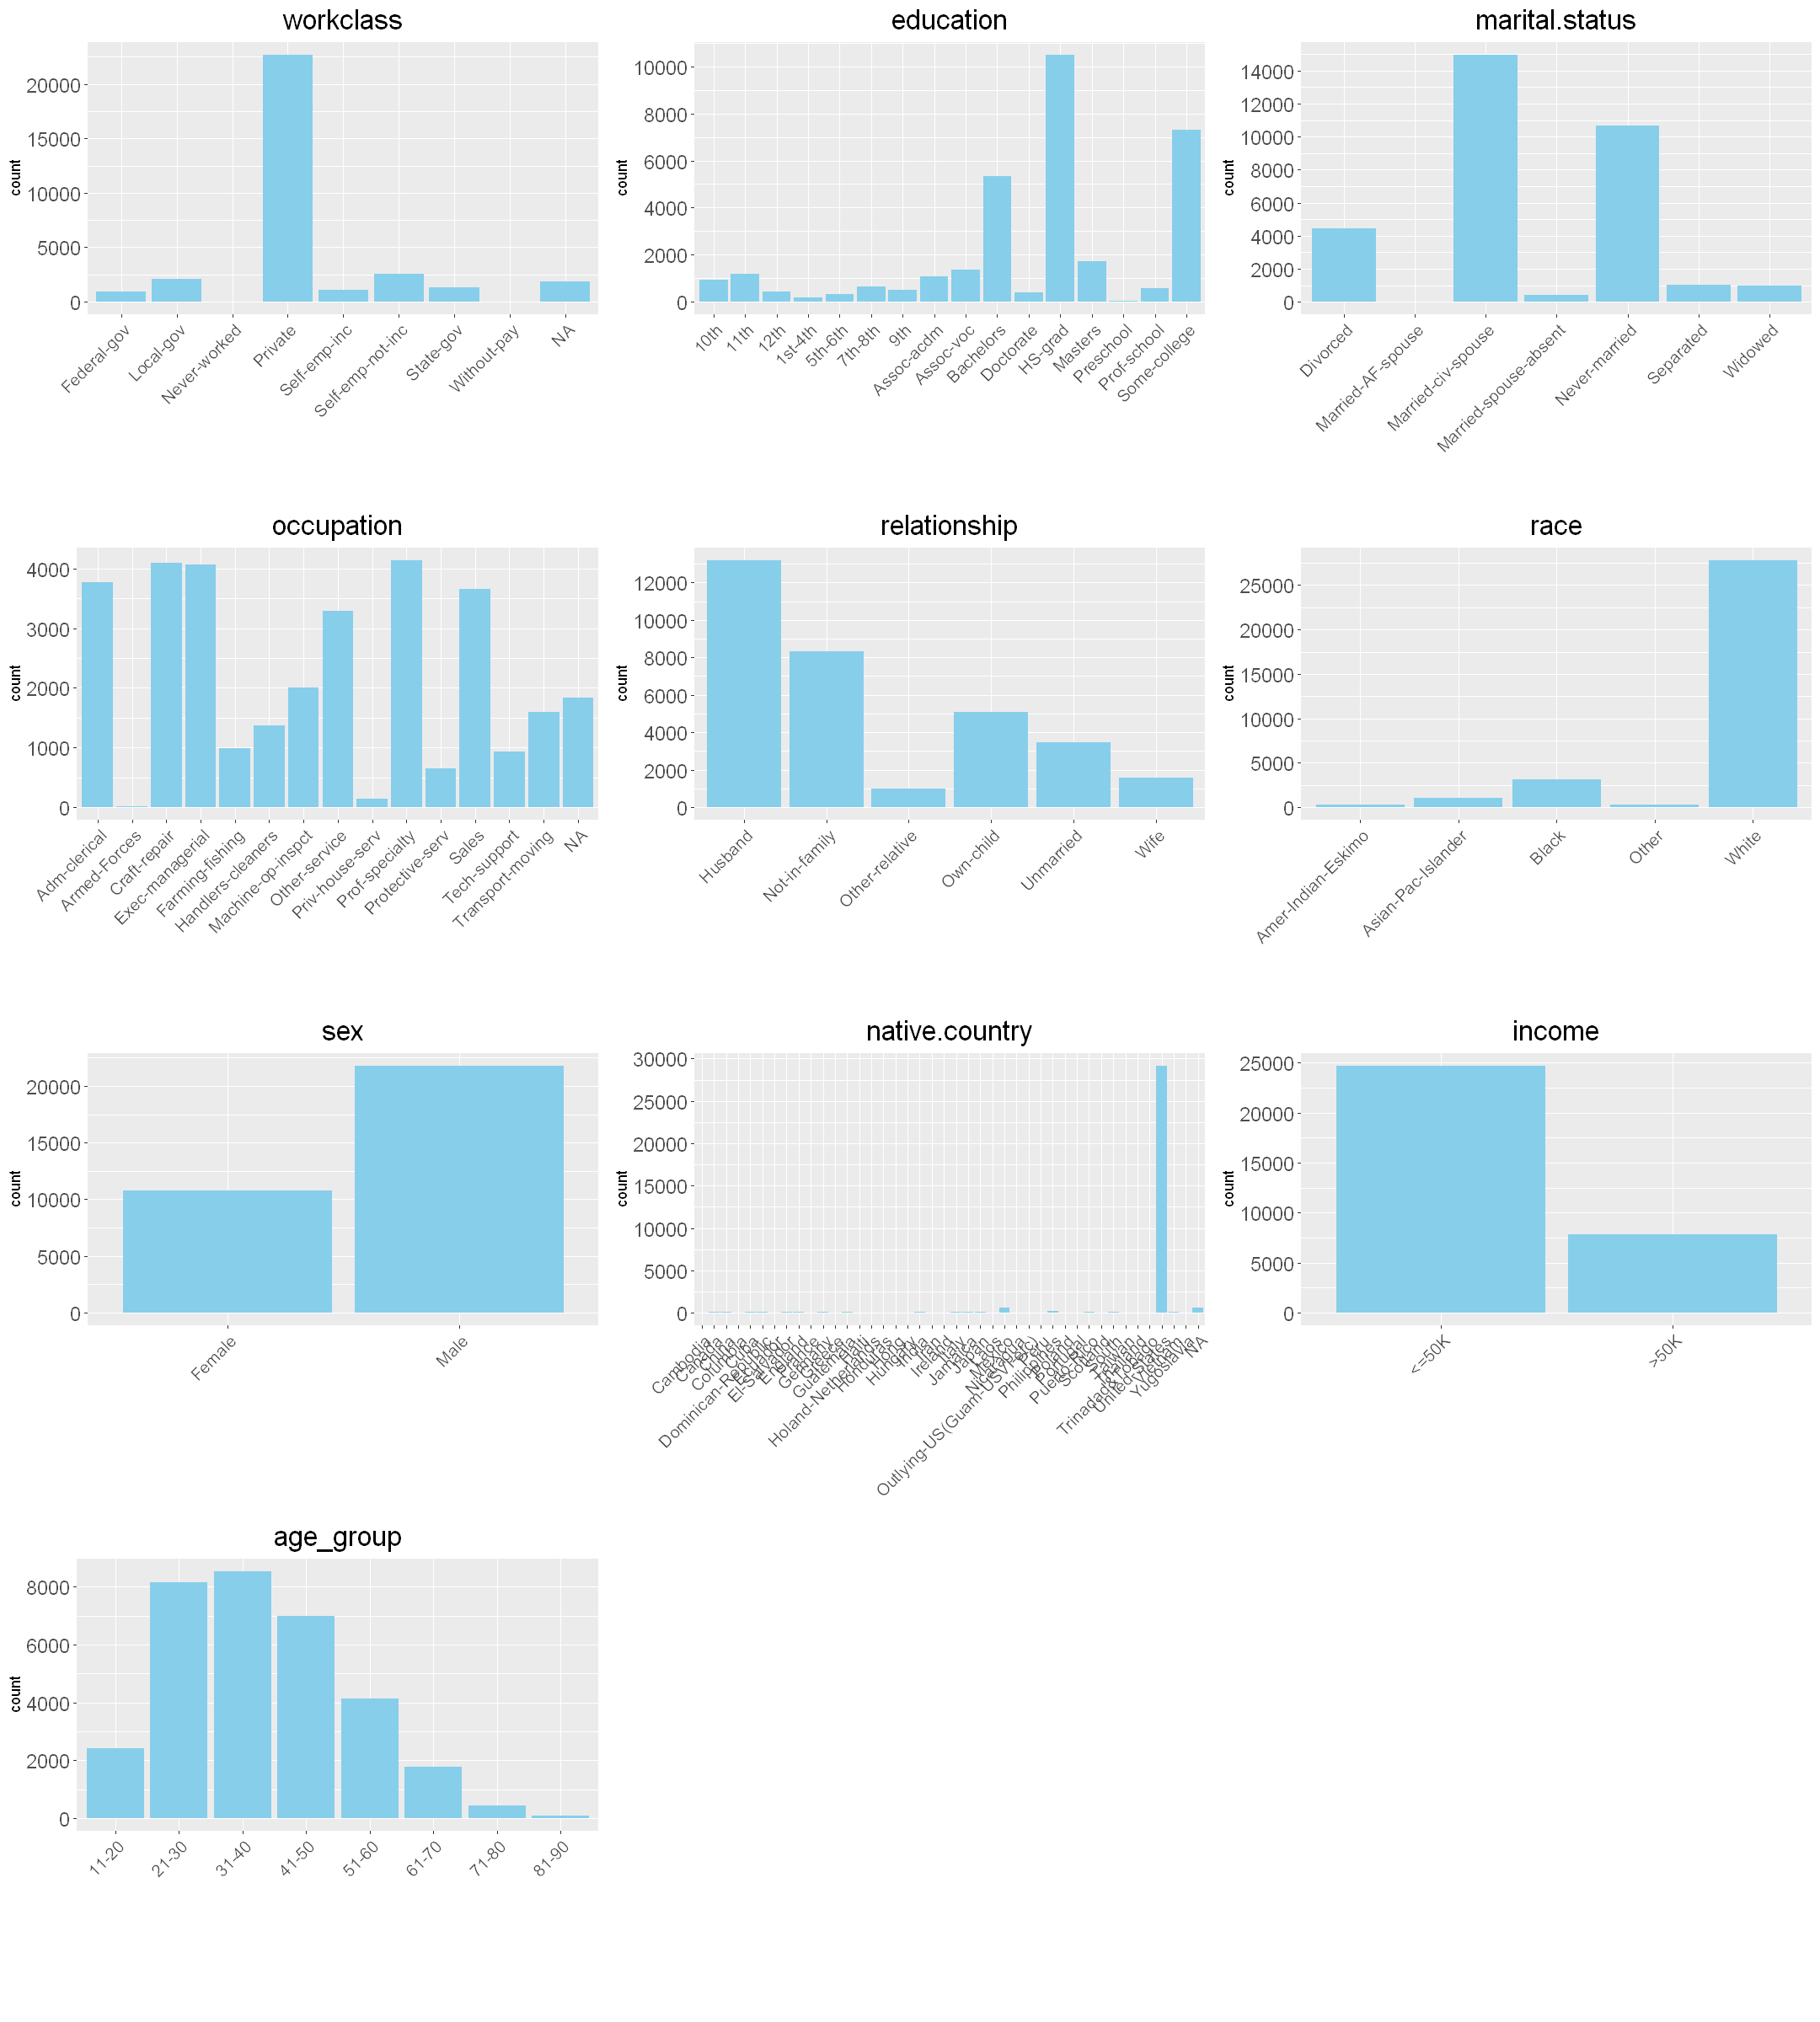

In [165]:
options(repr.plot.width=18, repr.plot.height=20)
plot_grid(plotlist = bar_plots, ncol = 3, align = "h")

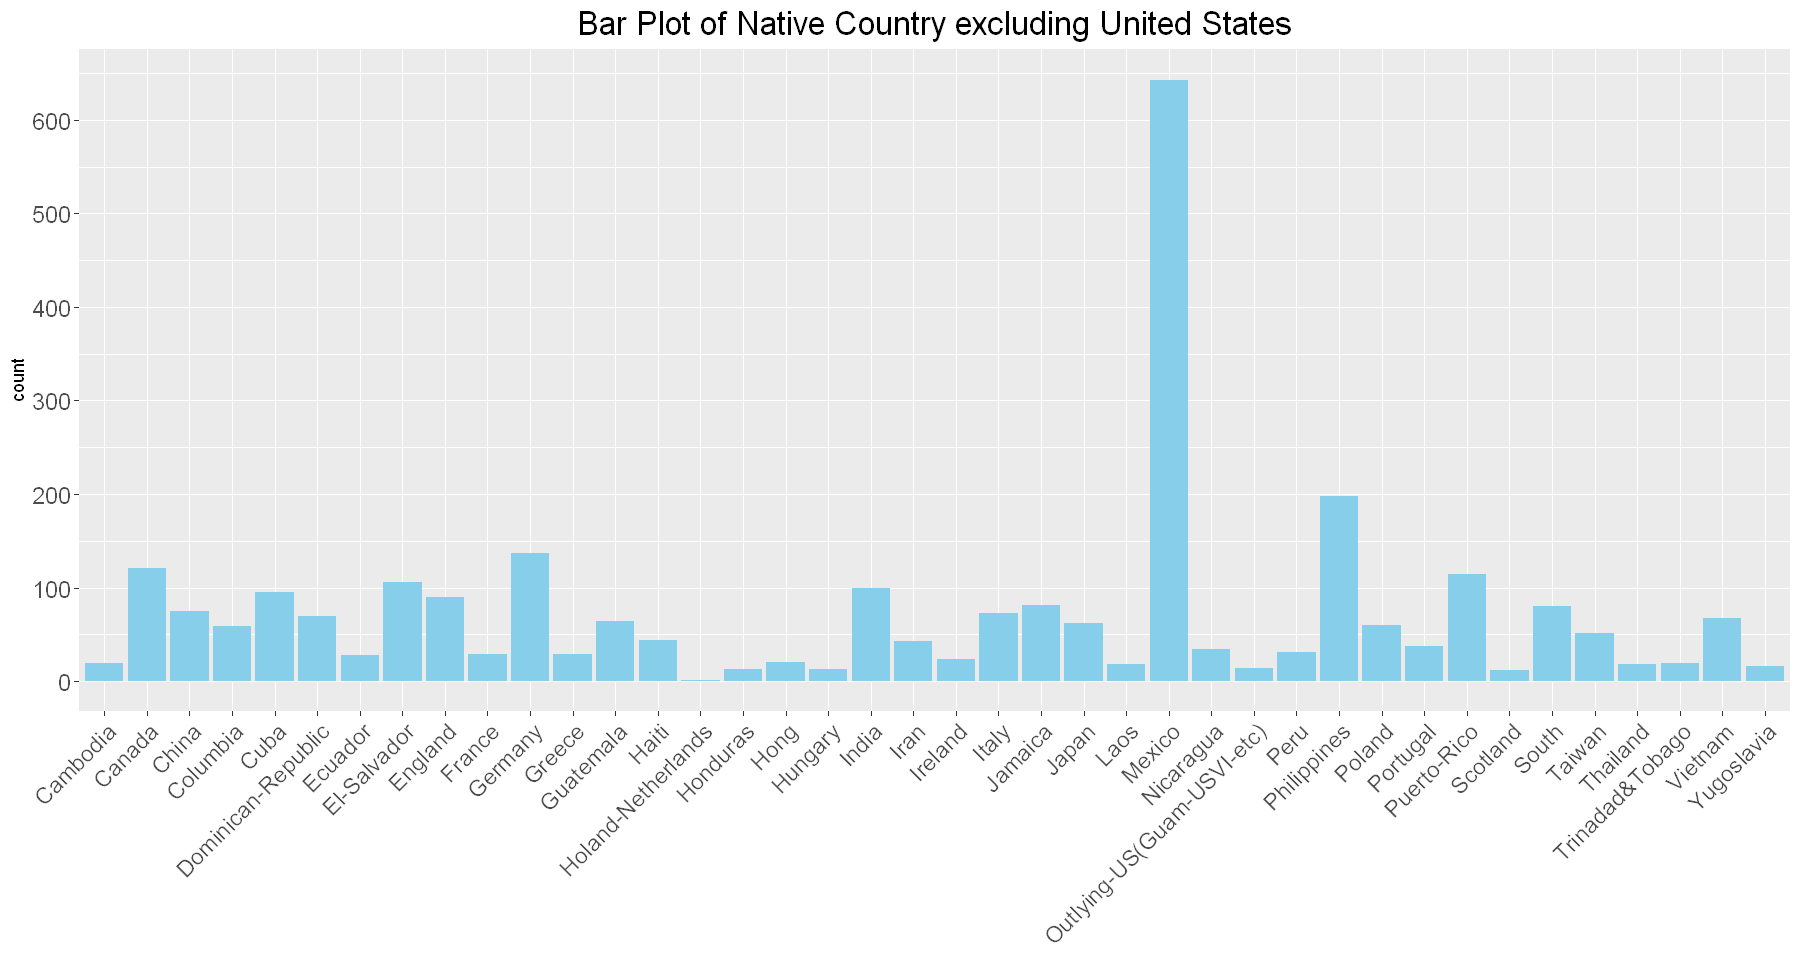

In [166]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(subset(adult_data, native.country != "United-States"), aes(x = native.country)) +
  geom_bar(fill='skyblue') +
  labs(title = "Bar Plot of Native Country excluding United States") +
  scale_y_continuous(breaks = pretty_breaks(n = 7)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
        axis.text.y = element_text(size=14),
        axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=20))

In [198]:
#how many percent of native.country data is united-states
mean(adult_data$native.country == 'United-States', na.rm = TRUE) * 100

[1] 91.21869

#### Histograms

In [168]:
histograms <- lapply(numerical_columns, function(column) {
  ggplot(adult_data, aes_string(x = column)) +
    geom_histogram(bins = 30, fill = 'skyblue', color ='#476E7D', size = 0.6) +
    labs(title = column) +
    scale_y_continuous(breaks = pretty_breaks(n = 6)) +
    scale_x_continuous(breaks = pretty_breaks(n=8)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
          axis.text.y = element_text(size=14),
          axis.title.x = element_blank(),
          plot.title = element_text(hjust = 0.5, size=20))
})

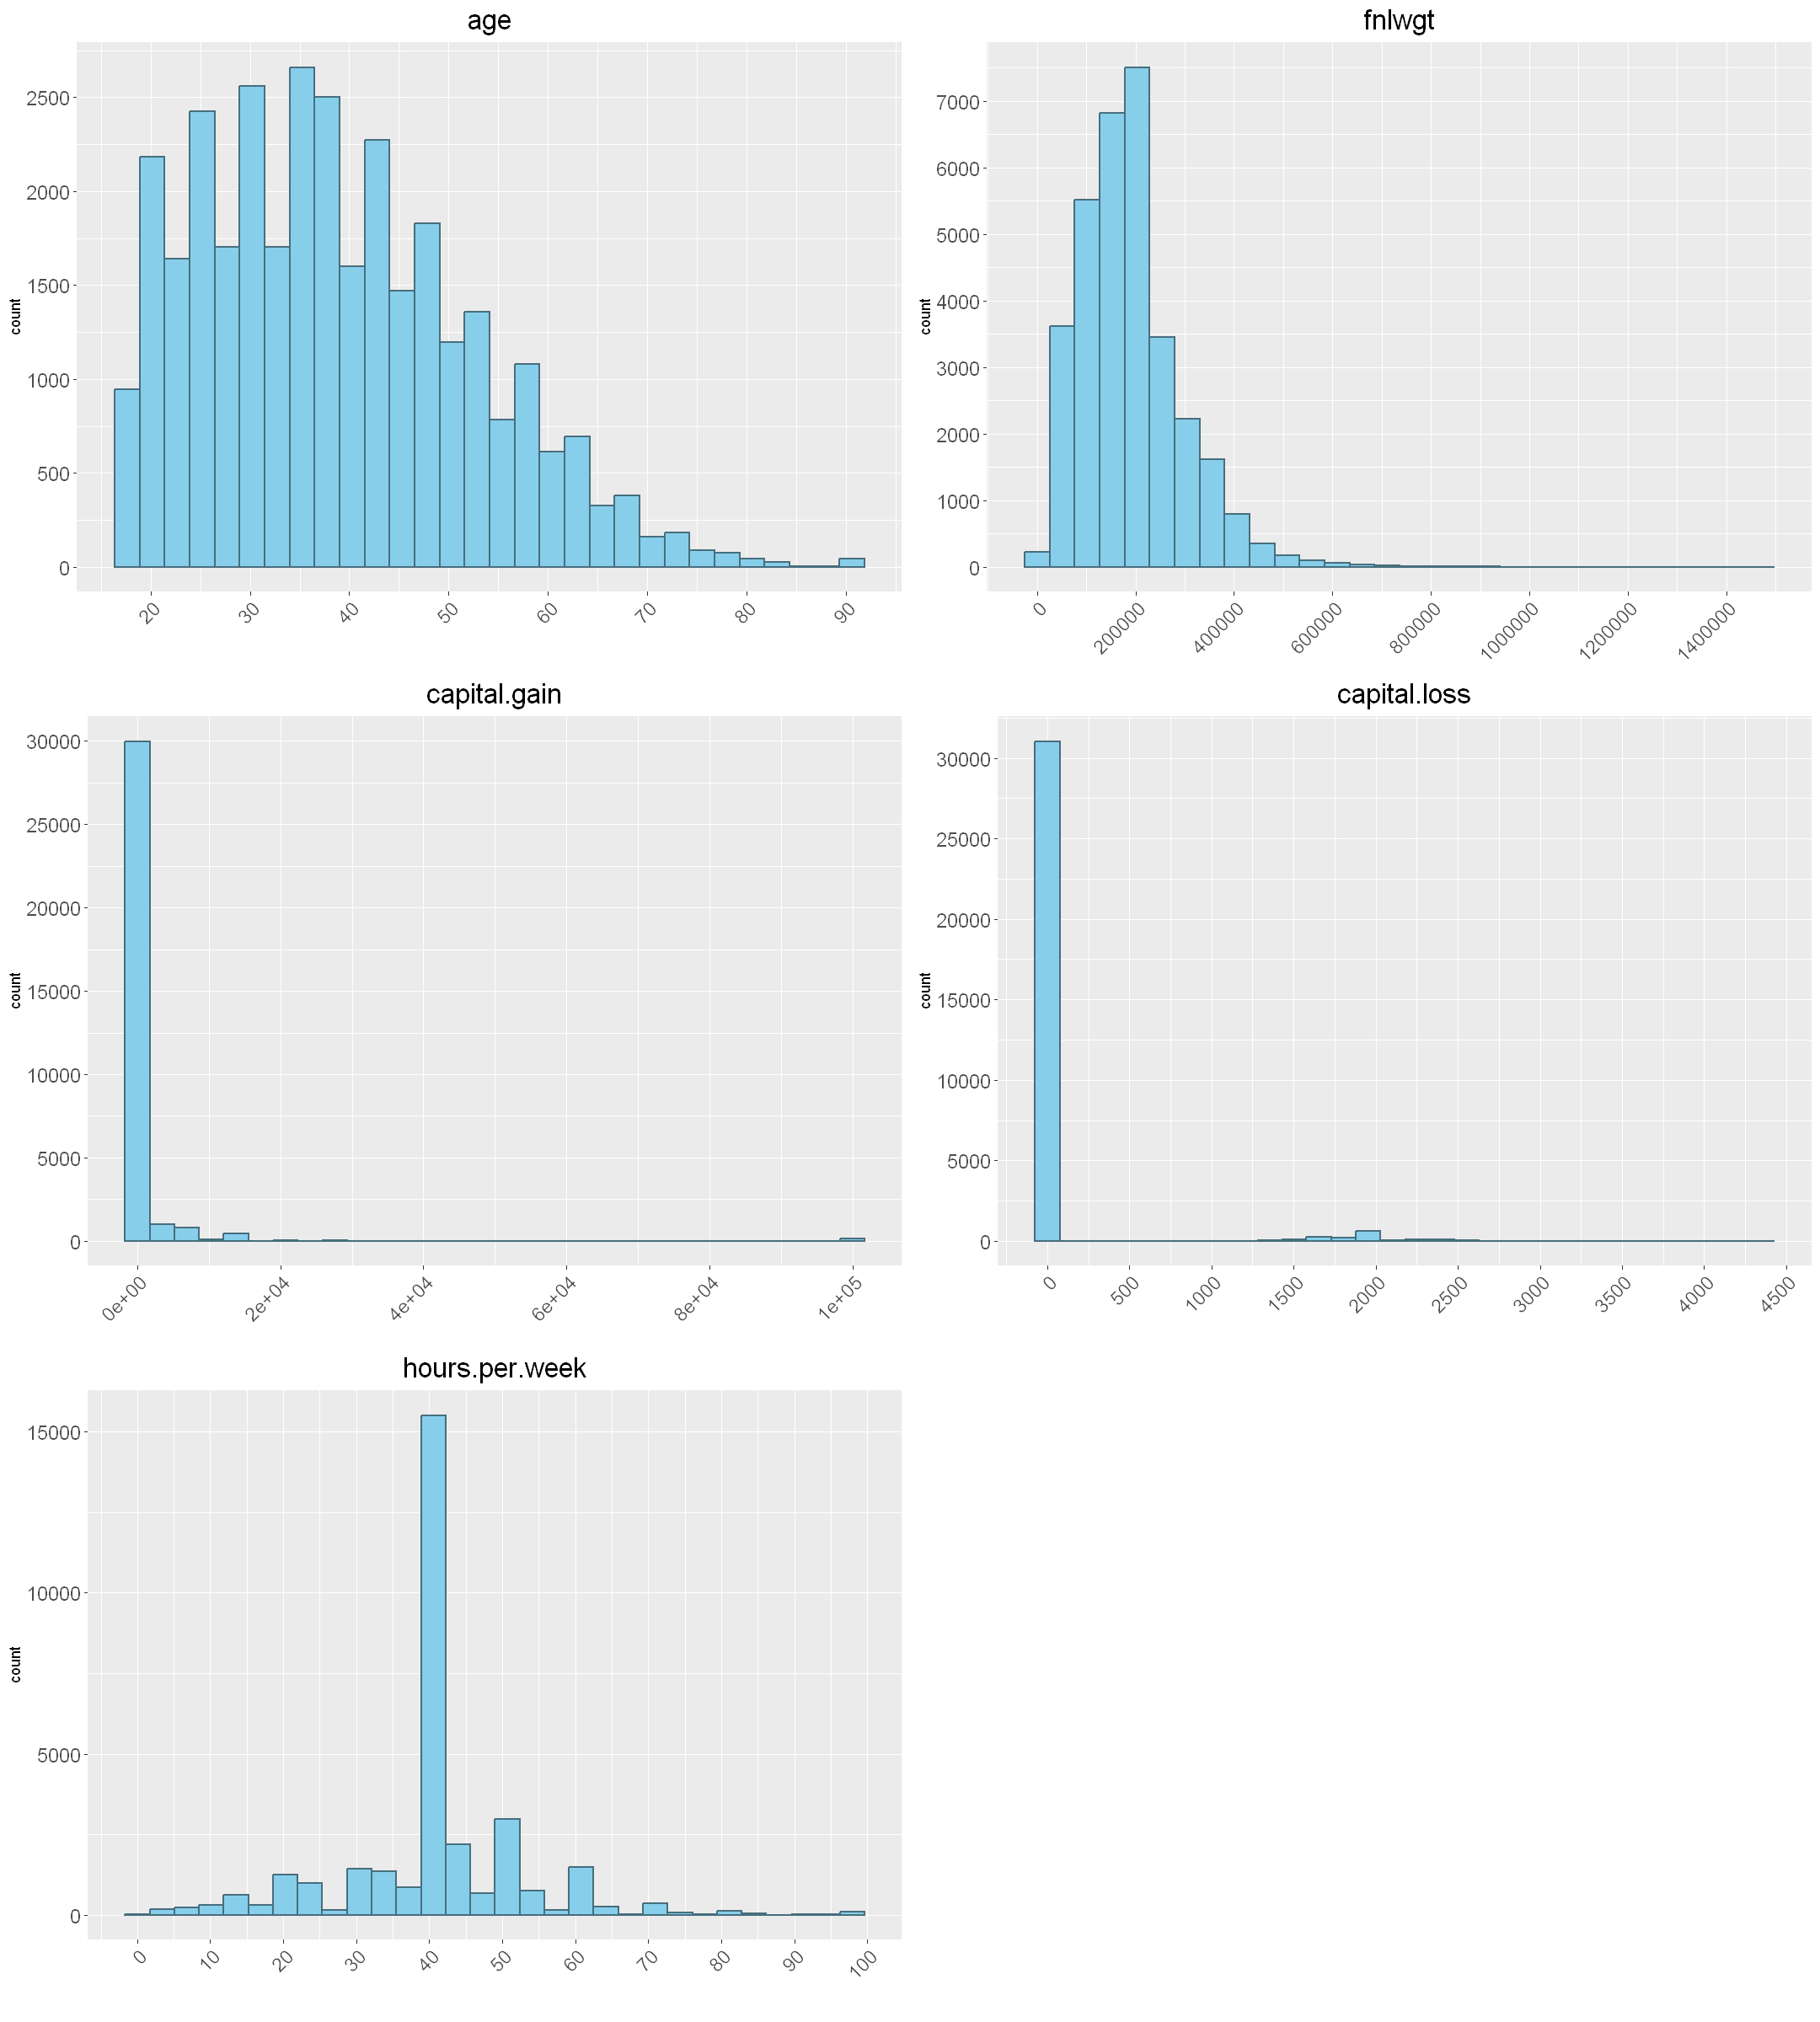

In [169]:
options(repr.plot.width=18, repr.plot.height=20)
plot_grid(plotlist = histograms, ncol = 2, align = "h")

#### Boxplots

In [170]:
boxplots <- lapply(c('age', 'fnlwgt', 'hours.per.week'), function(column) {
  ggplot(adult_data, aes_string(y = column)) +
    geom_boxplot(fill = "skyblue", color = "#476E7D") +
    labs(title = paste(column)) +
    scale_y_continuous(breaks = pretty_breaks(n = 10)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
          axis.text.y = element_text(size=14),
          axis.title.y = element_text(size=14),
          axis.title.x = element_blank(),
          plot.title = element_text(hjust = 0.5, size=20))
})

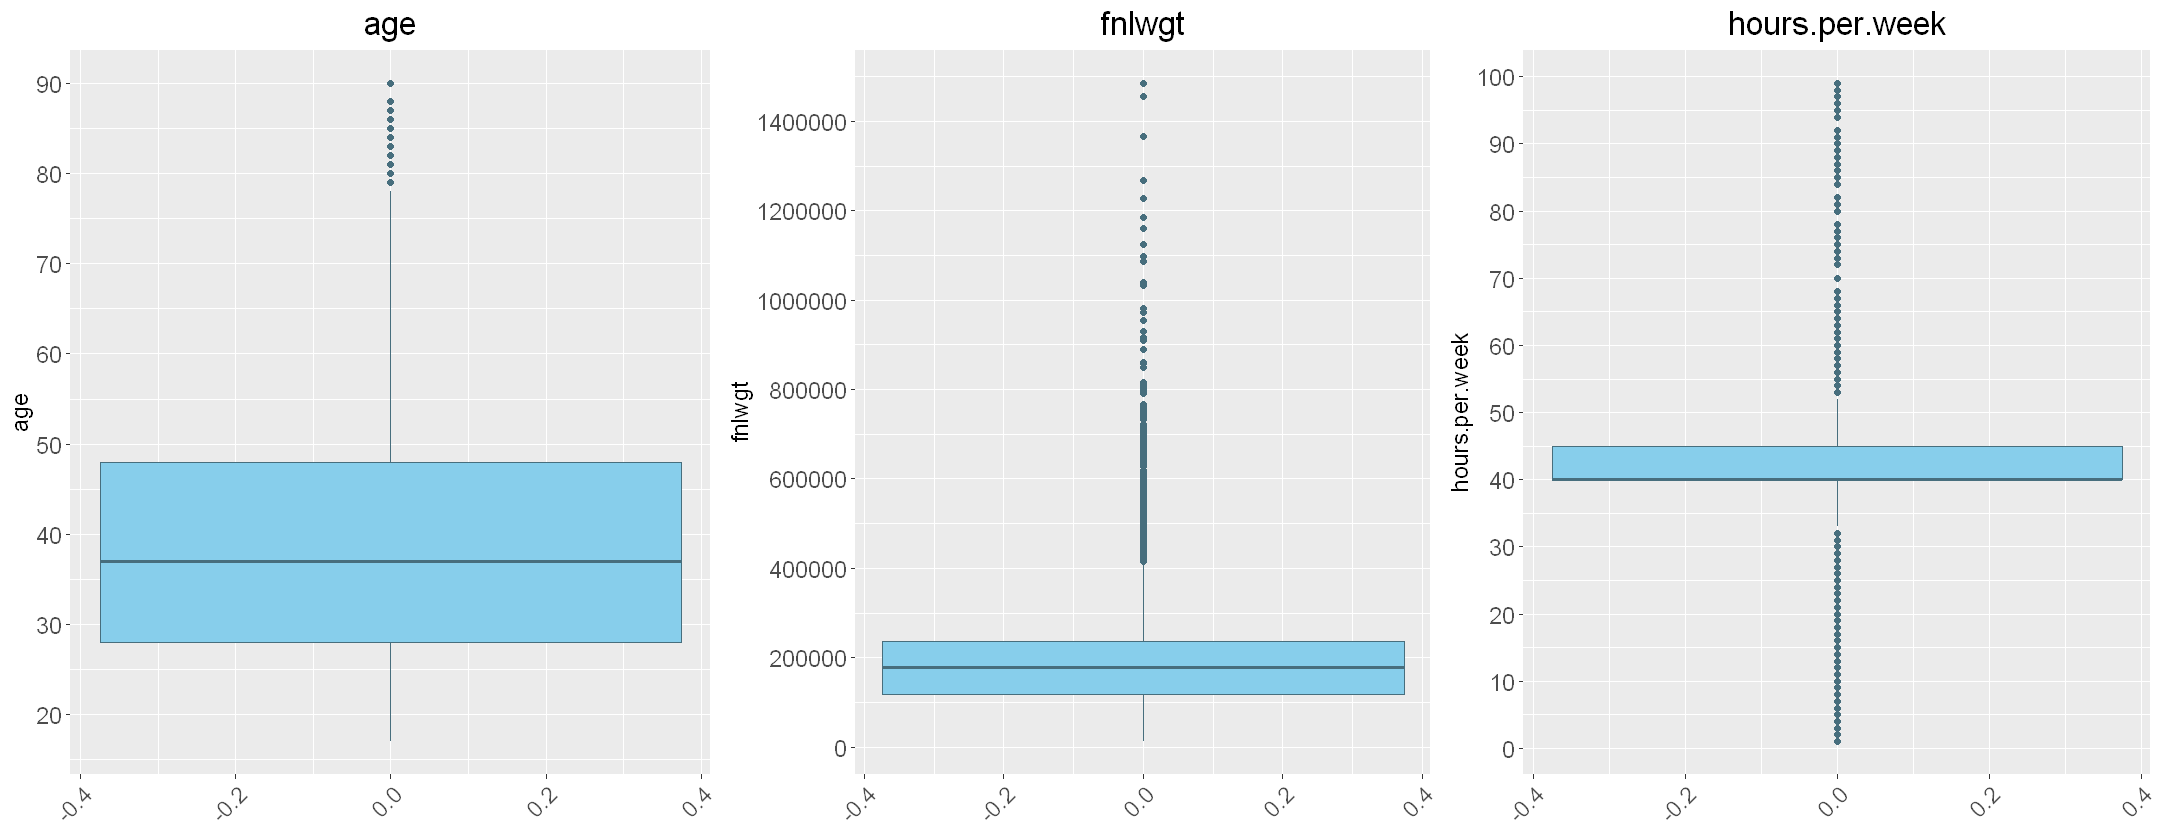

In [171]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(plotlist = boxplots, ncol = 3, align = "h")

### Looking for dependencies

We have sometimes 99 hours worked per week. A litte bit too much. But maybe in some private companies or in hospital? Let's check relation ship of hours per week worked and occupation.

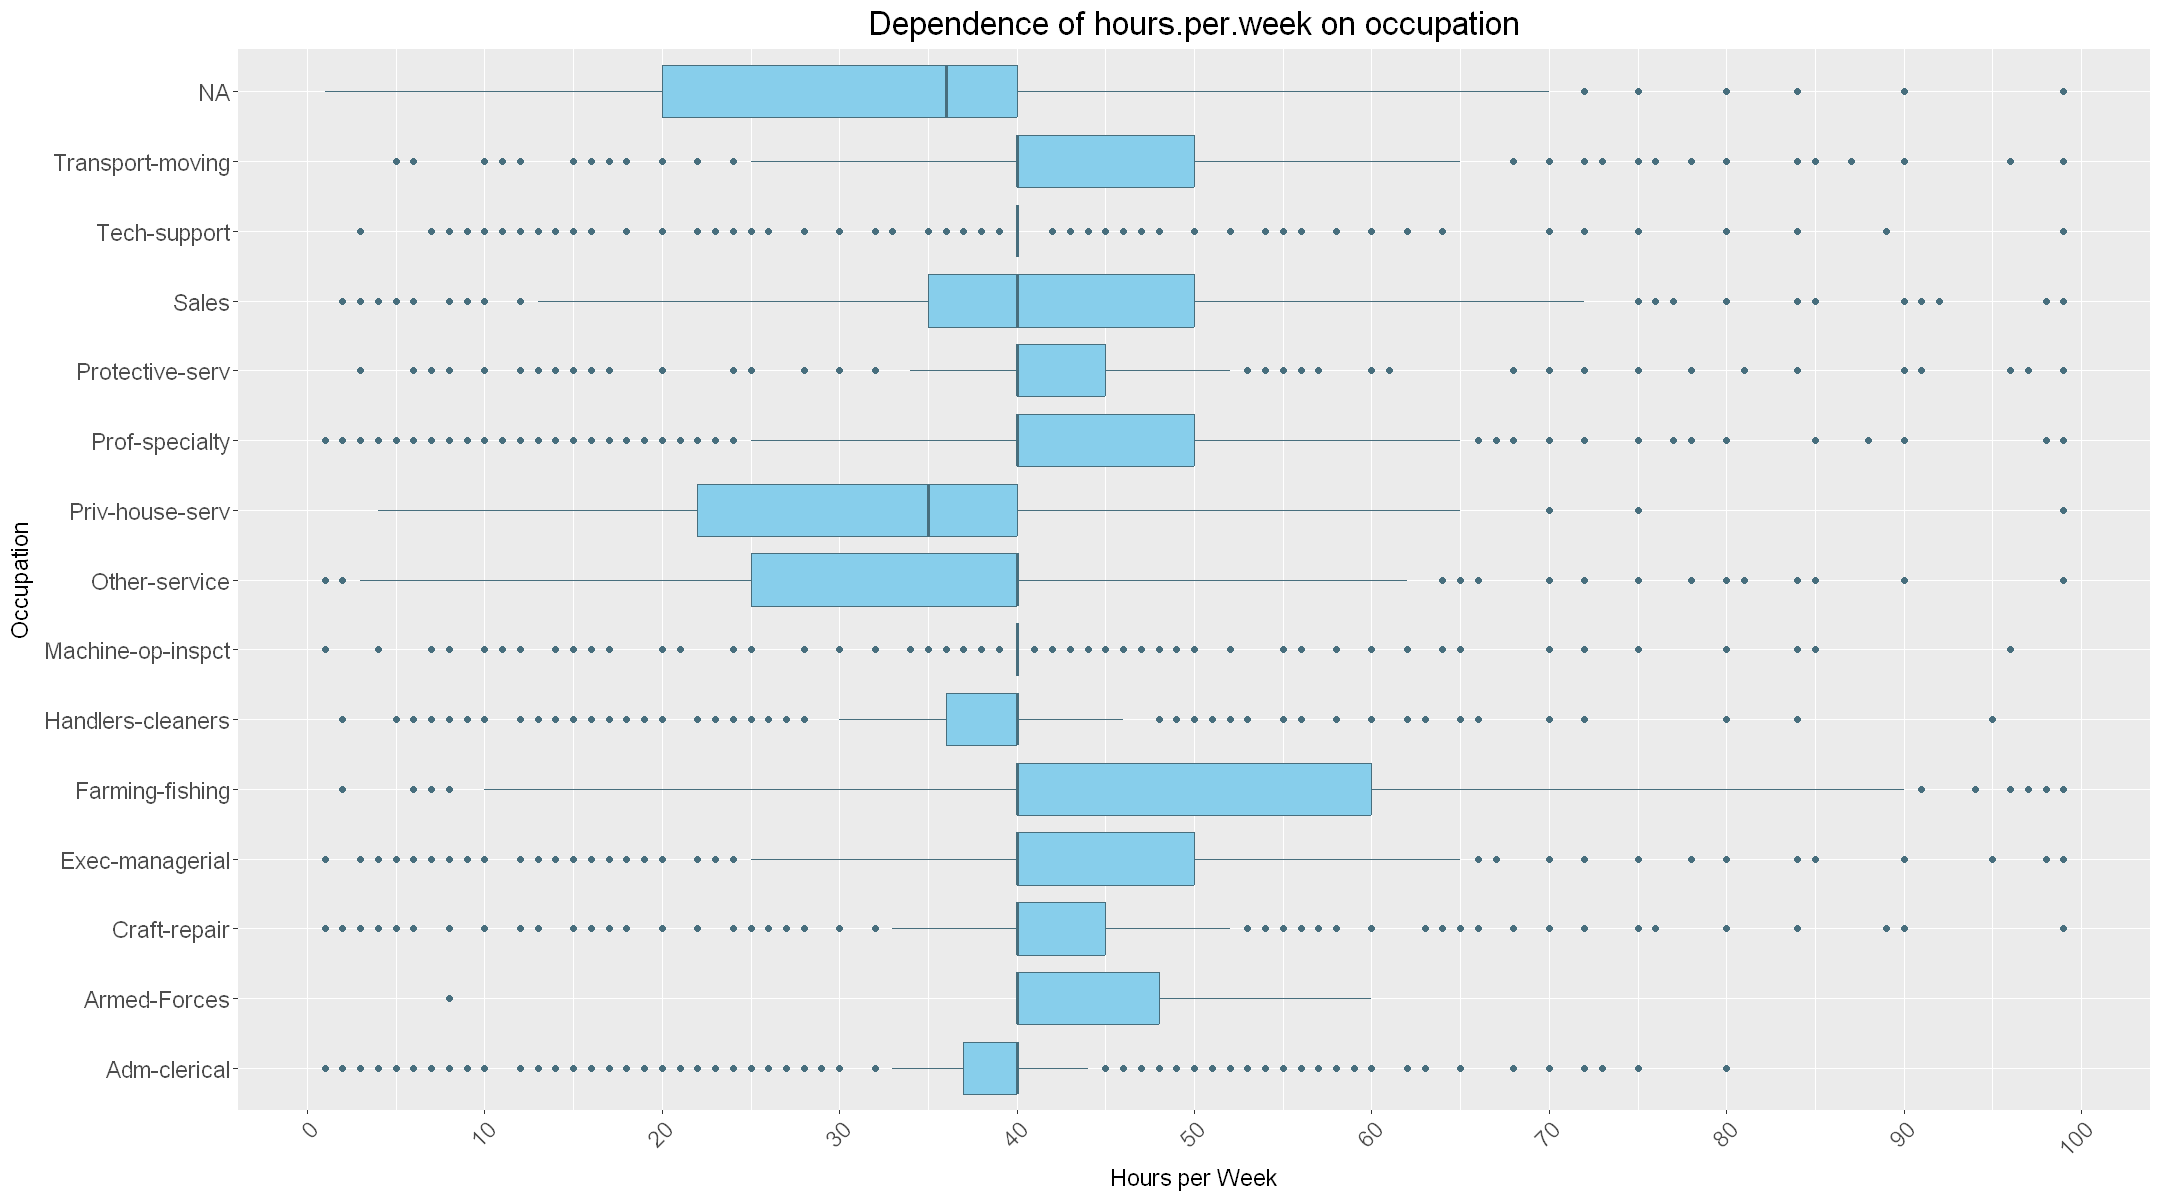

In [172]:
options(repr.plot.width=18, repr.plot.height=10)
ggplot(adult_data, aes(x = occupation, y = hours.per.week)) +
geom_boxplot(fill = 'skyblue', color = "#476E7D") +
coord_flip() + 
scale_y_continuous(breaks = pretty_breaks(n = 10)) +
labs(title = "Dependence of hours.per.week on occupation", x = "Occupation", y = "Hours per Week") +
theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
      axis.text.y = element_text(size=14),
      axis.title.y = element_text(size=14),
      axis.title.x = element_text(size=14),
      plot.title = element_text(hjust = 0.5, size=20))

In [173]:
adult_data <- adult_data %>%
  mutate(age_group = cut(age, breaks = c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90), labels = c("0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90")))

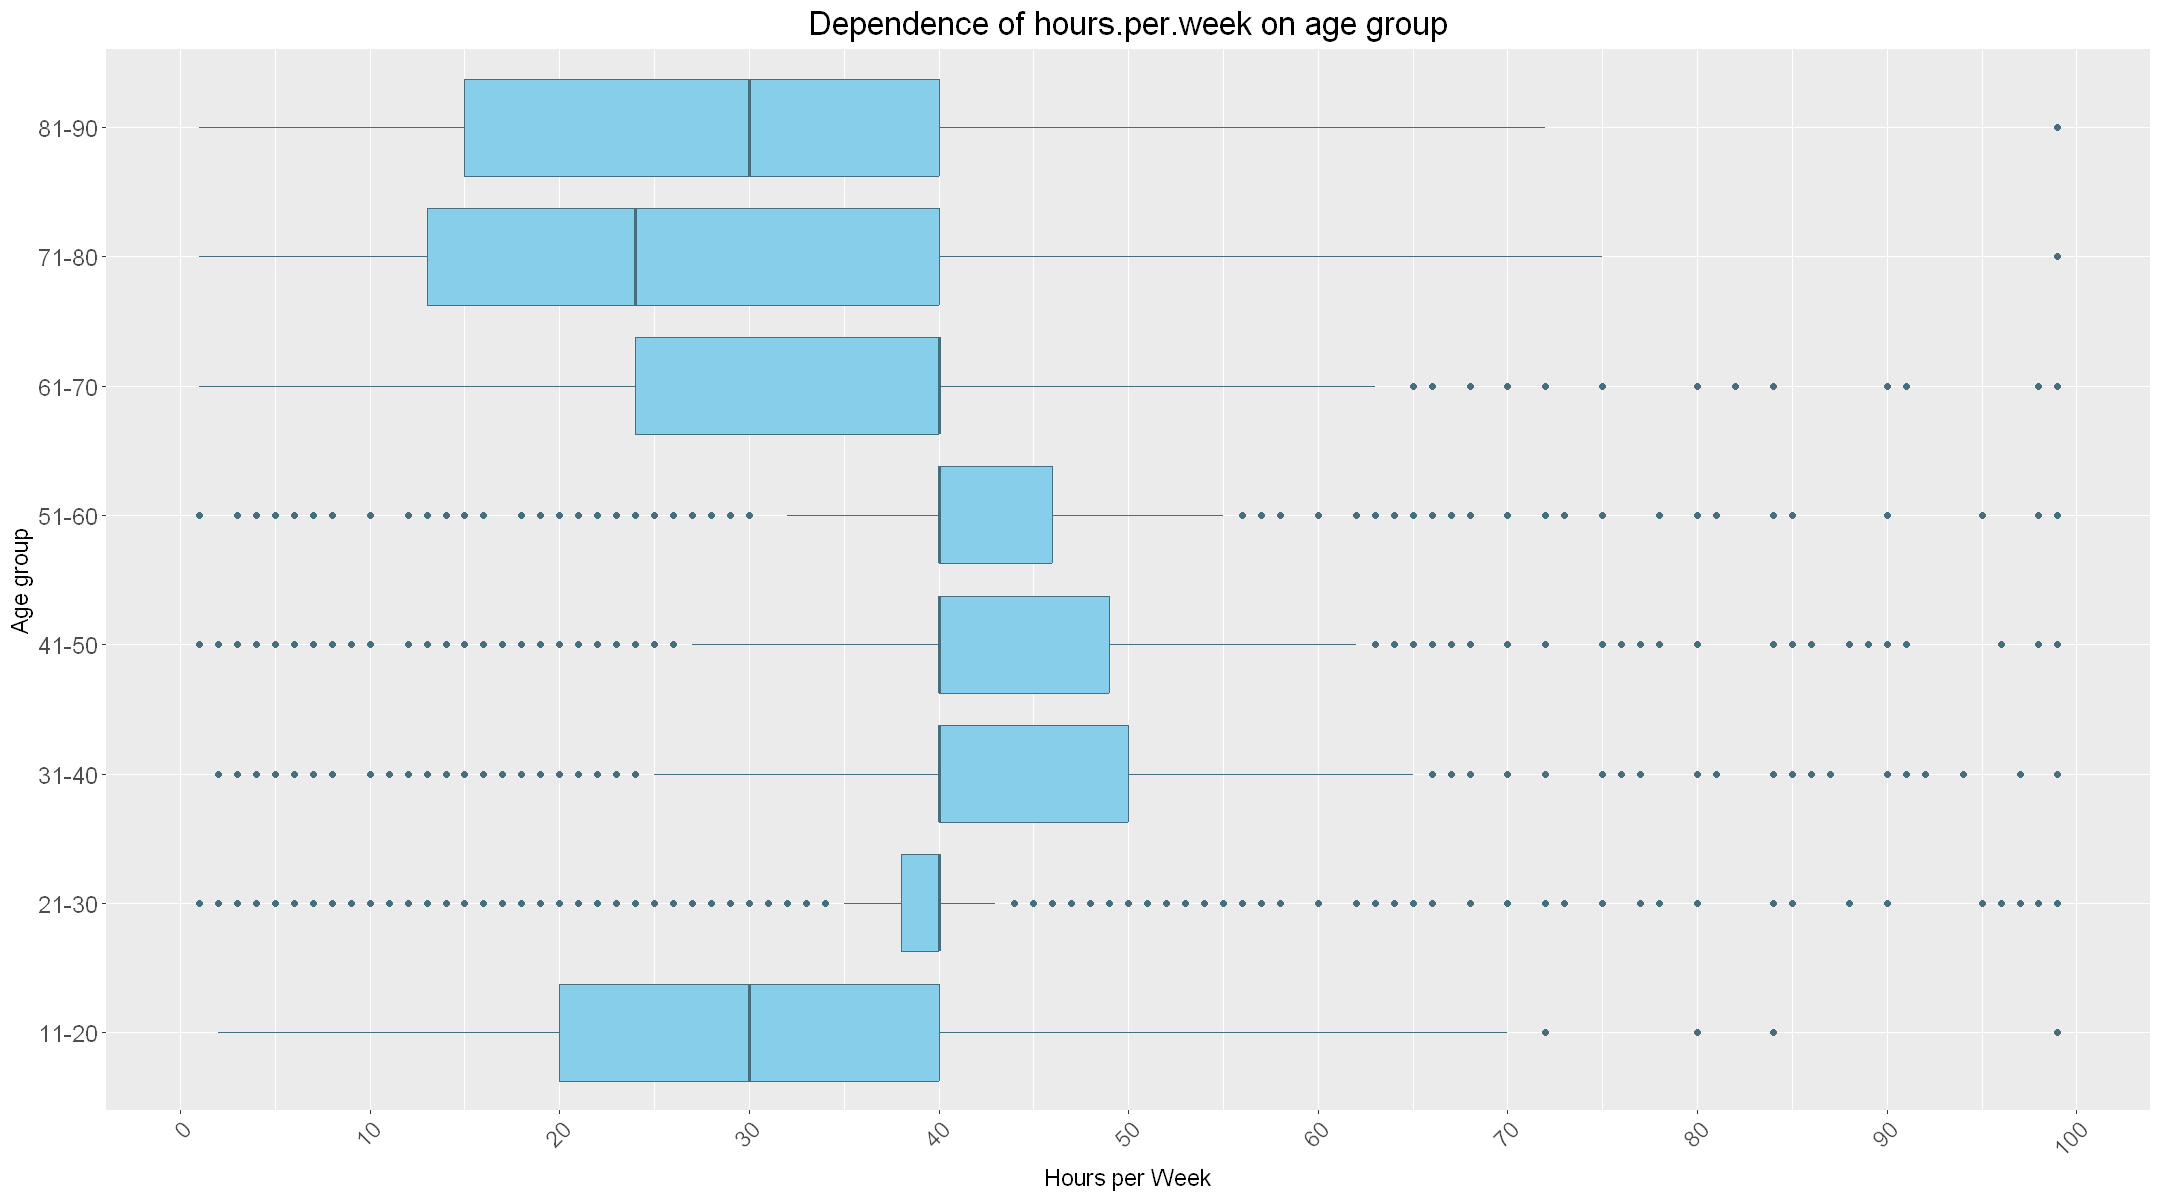

In [174]:
ggplot(adult_data, aes(x = age_group, y = hours.per.week)) +
geom_boxplot(fill = 'skyblue', color = "#476E7D") +
coord_flip() + 
scale_y_continuous(breaks = pretty_breaks(n = 10)) +
labs(title = "Dependence of hours.per.week on age group", x = "Age group", y = "Hours per Week") +
theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
      axis.text.y = element_text(size=14),
      axis.title.y = element_text(size=14),
      axis.title.x = element_text(size=14),
      plot.title = element_text(hjust = 0.5, size=20))

#### Check what is capital gain and loss

In [175]:
cor(adult_data$capital.gain, adult_data$capital.loss)

[1] -0.03161411

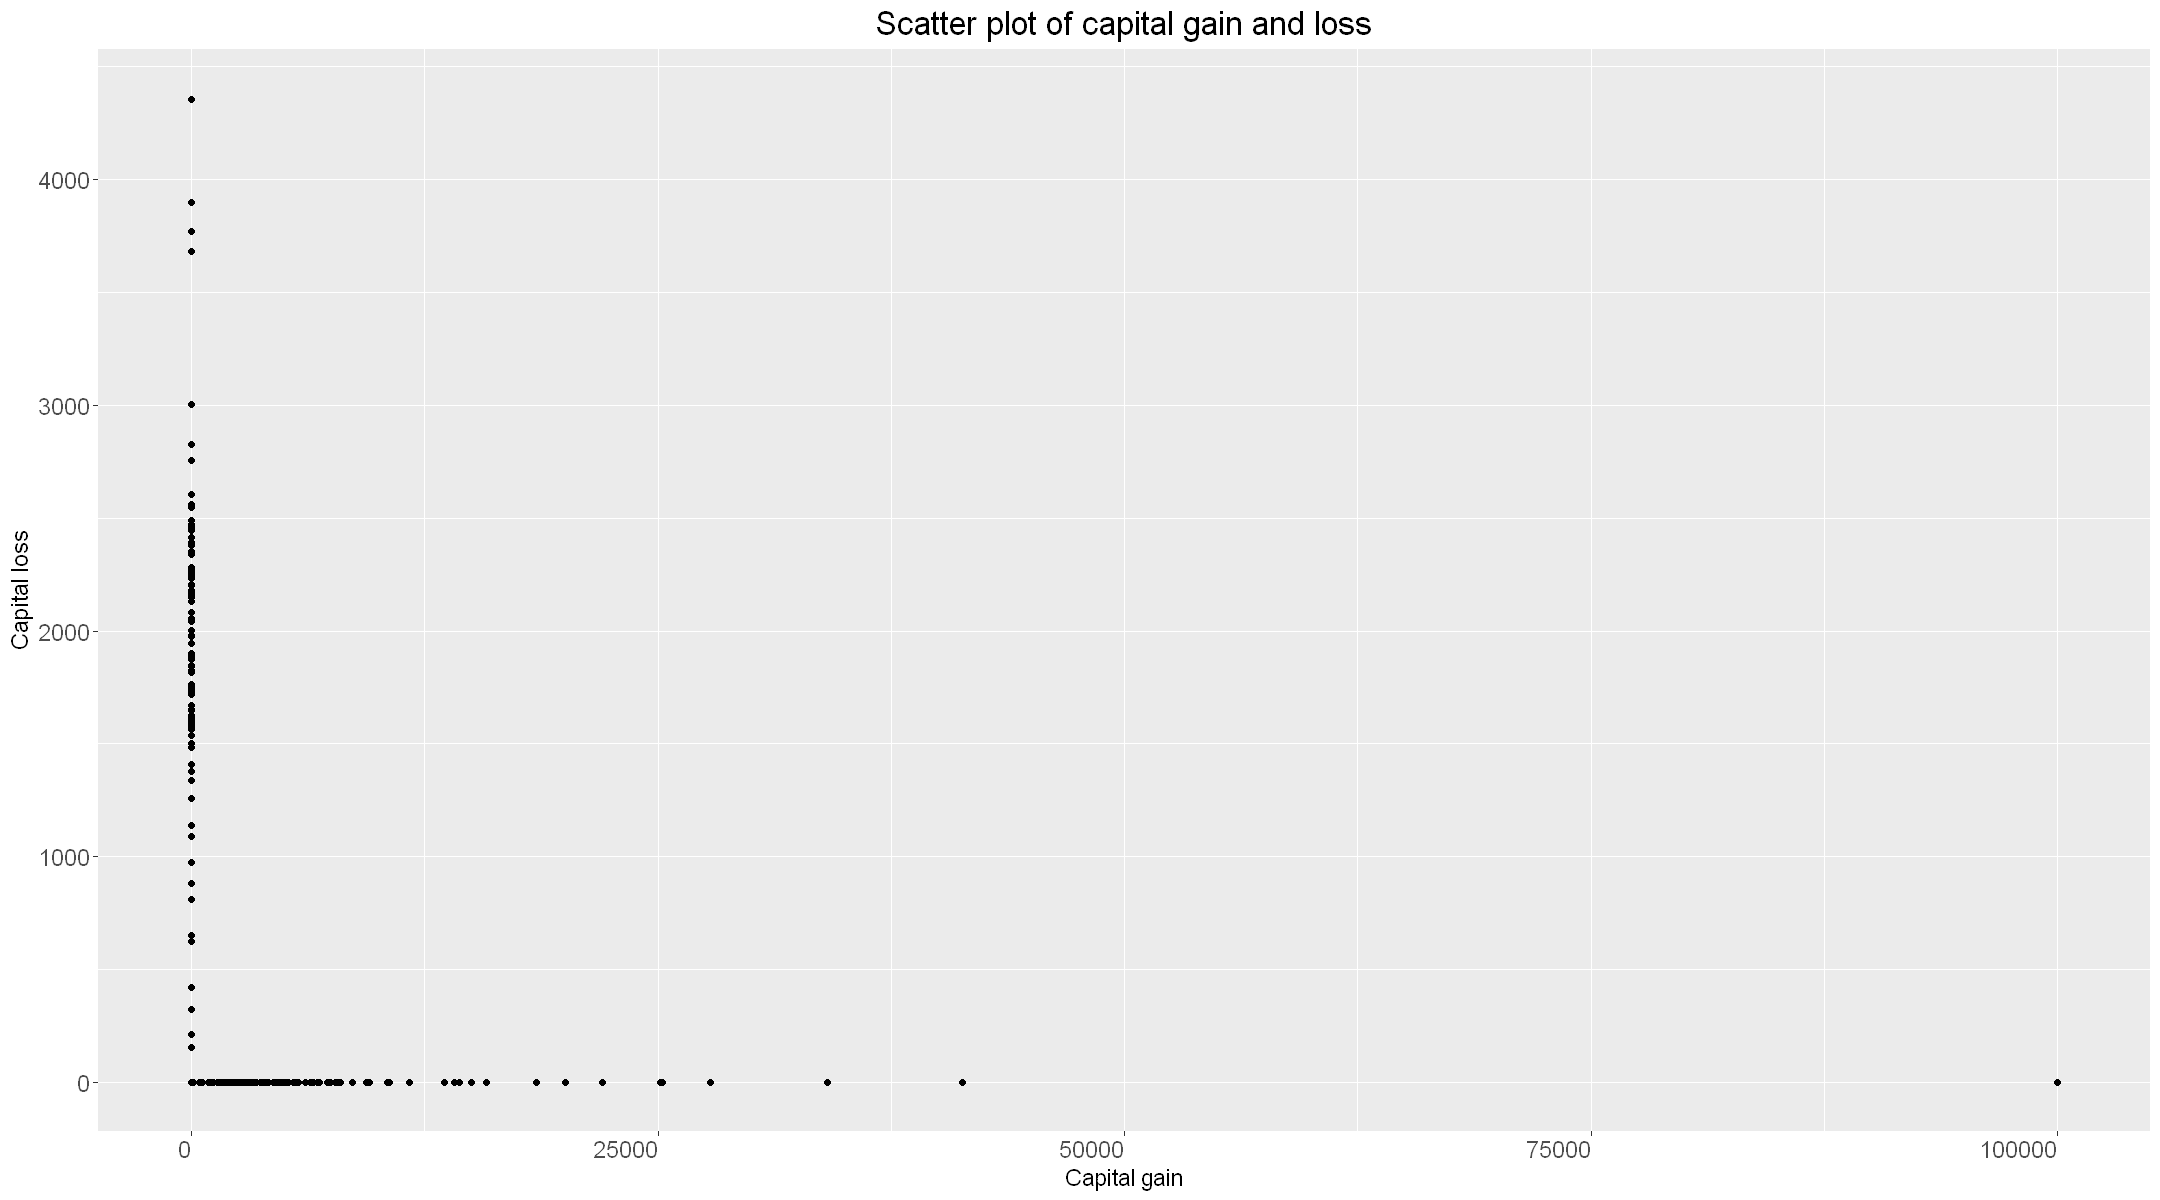

In [176]:
ggplot(adult_data, aes(x = capital.gain, y = capital.loss)) +
  geom_point() +
  labs(x = "Capital gain", y = "Capital loss",
       title = "Scatter plot of capital gain and loss") +
  theme(axis.text = element_text(hjust = 1, size=14),
        axis.title = element_text(size=14),
        plot.title = element_text(hjust = 0.5, size=20))

In [177]:
sum(adult_data$capital.gain == 0)
sum(adult_data$capital.loss == 0)

[1] 29849

[1] 31041

In [178]:
sum(adult_data$capital.gain == 0 & adult_data$capital.loss == 0)

[1] 28330

In [179]:
sum(adult_data$capital.gain == 0 & adult_data$capital.loss > 0)
sum(adult_data$capital.loss == 0 & adult_data$capital.gain > 0)

[1] 1519

[1] 2711

In [180]:
28330 + 1519 + 2711
nrow(adult_data)

[1] 32560

[1] 32560

#### Correlations

In [181]:
adult_data$income_binary <- ifelse(adult_data$income == ">50K", 1, 0)

correlations <- sapply(adult_data[factor_columns], function(column) {
  cor(adult_data$income_binary, as.numeric(column))
})

correlation_df <- data.frame(Correlation = correlations)

In [182]:
correlation_df

,Correlation
,<dbl>
workclass,NA
education,0.07931133
marital.status,-0.19929464
occupation,NA
relationship,-0.25092447
race,0.07185294
sex,0.21599500
native.country,NA
income,1.00000000


In [183]:
correlations_numerical <- sapply(adult_data[numerical_columns], function(column) {
  cor(adult_data$income_binary, column)
})

correlation_numerical_df <- data.frame(Correlation = correlations_numerical)

In [184]:
correlation_numerical_df

,Correlation
,<dbl>
age,0.234038777
fnlwgt,-0.009481166
capital.gain,0.223332549
capital.loss,0.150523406
hours.per.week,0.229689576


As the correlation between dependent variables increases, then decreases their usefulness. Some models require that features should be independent. Keeping high correlation between predictors may even decrease the performance. Let's take a look at the correlation matrix.

In [185]:
correlation_matrix <- cor(adult_data[sapply(adult_data, is.numeric)])
correlation_data <- reshape2::melt(correlation_matrix)

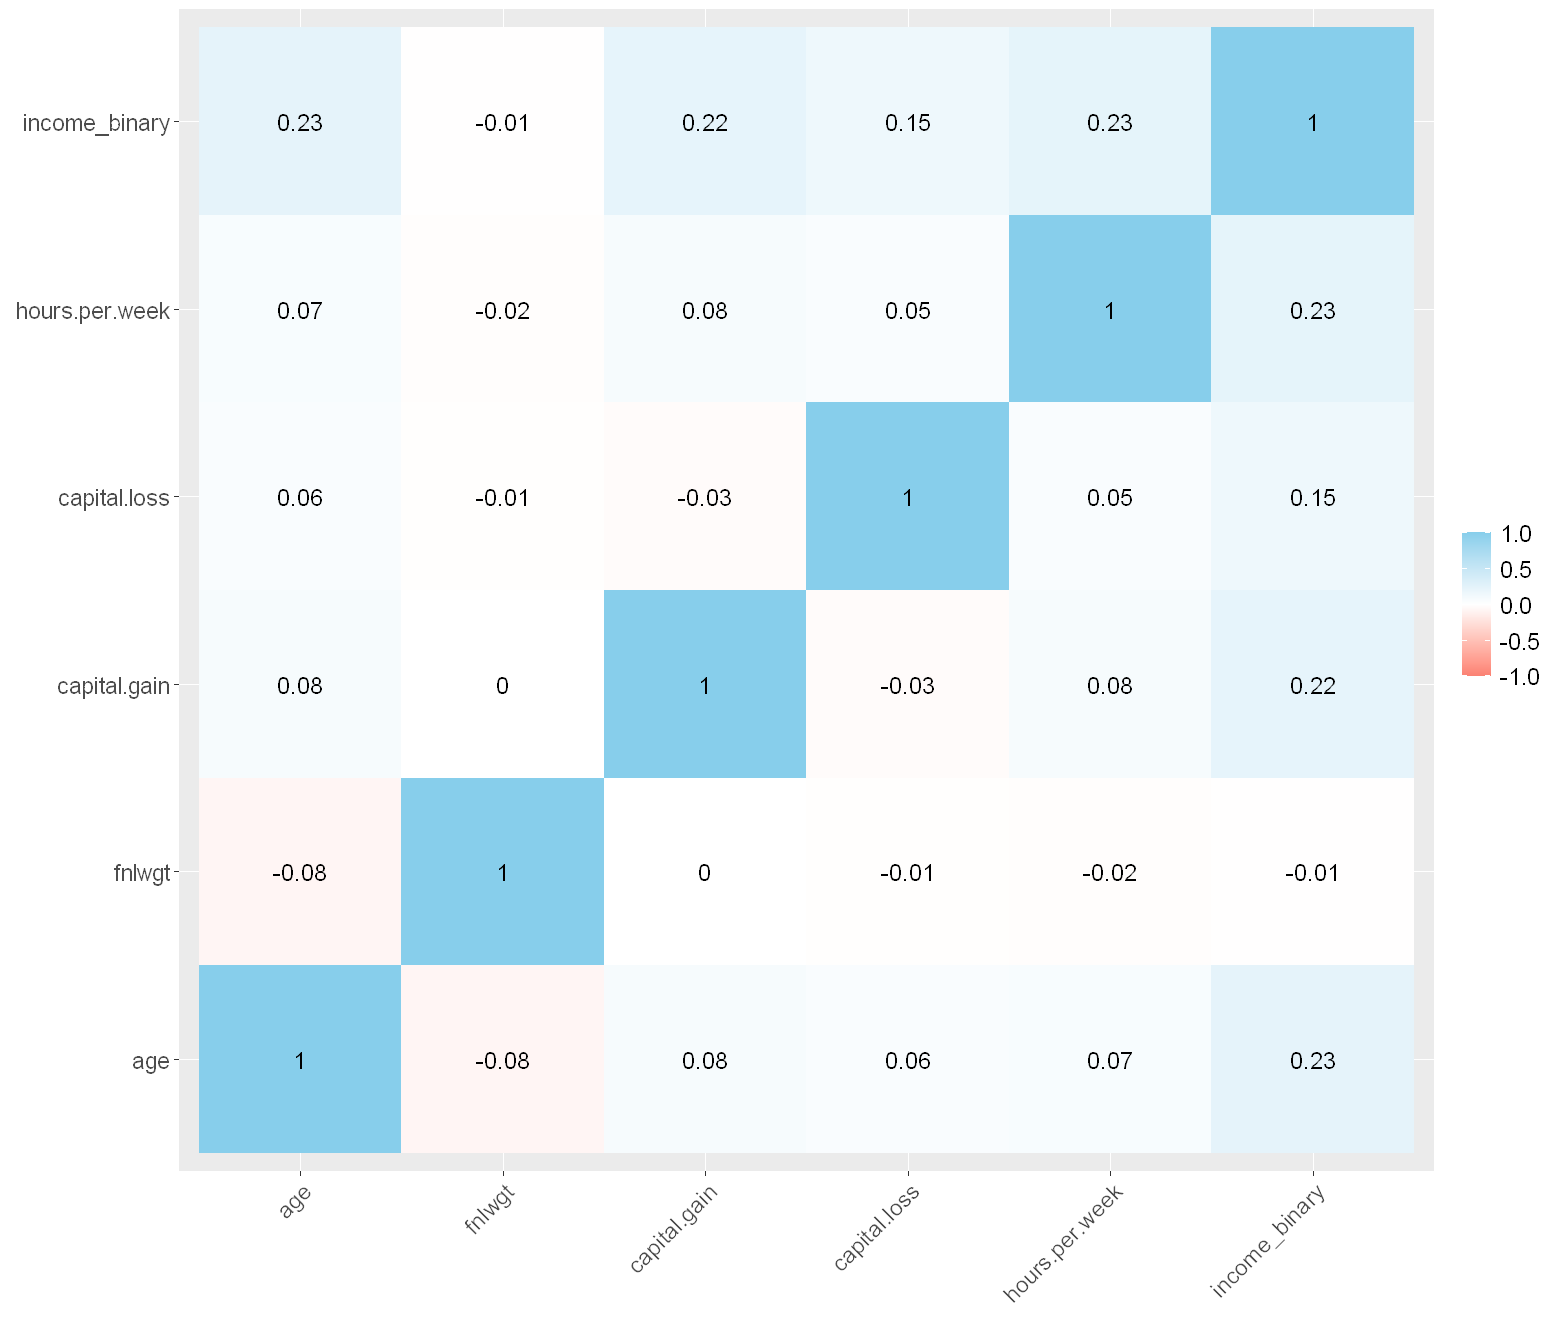

In [186]:
options(repr.plot.width=13, repr.plot.height=11)
ggplot(data = correlation_data, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "#FA8072", mid = "white", high = "#87CEEB",
                       midpoint = 0, limits = c(-1, 1), name = "") +
  geom_text(aes(label = round(value, 2)), size = 5) + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),  
        axis.text.y = element_text(size = 14),  
        axis.title = element_blank(),
        legend.position = "right",
        legend.text = element_text(size = 14))  

We shouldn't omit analysis of the dependency between categorical variables. For that, we will use the chi square test, which measure the independence in influencing the test statistics. The higher the p-value the more dependent the variables are. Let's plot the heatmap, in which each cell represents the p-value of the chi square test between two variables. 

In [187]:
#nie wiem jak to zrobić totalnie i czy w ogóle się da

#### Contigency tables

To check if some columns are imbalanced regarding income - then get rid off them.

In [199]:
#jesli usuniemy nany to mozna to zostawic i zrobic te cont na danych bez nanow, jesli nie usuwamy to to usunac

In [188]:
cont_table <- function(column) {
  result <- adult_data %>%
    group_by({{column}}, income, .drop = FALSE) %>%
    summarise(count = n(), .groups = "drop_last") %>%
    ungroup() %>%
    pivot_wider(names_from = {{column}}, values_from = count, values_fill = 0)
  return(result)
}

In [189]:
cont_table(workclass)

income,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,589,1476,7,17733,494,1817,944,14,1645
>50K,0,371,617,0,4963,622,724,353,0,191


In [83]:
cont_table(education)

income,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,871,1115,400,162,317,606,487,802,1021,3133,107,8826,764,51,153,5904
>50K,62,60,33,6,16,40,27,265,361,2221,306,1675,959,0,423,1387


In [84]:
cont_table(marital.status)

income,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3980,13,8284,384,10191,959,908
>50K,463,10,6692,34,491,66,85


In [85]:
cont_table(occupation)

income,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,3262,8,3170,2098,879,1284,1752,3158,148,2281,438,2667,645,1277,1652
>50K,507,1,929,1968,115,86,250,137,1,1859,211,983,283,320,191


In [86]:
cont_table(relationship)

income,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,7275,7448,944,5001,3228,823
>50K,5918,856,37,67,218,745


In [87]:
cont_table(race)

income,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
<fct>,<int>,<int>,<int>,<int>,<int>
<=50K,275,763,2737,246,20698
>50K,36,276,387,25,7117


In [88]:
cont_table(sex)

income,Female,Male
<fct>,<int>,<int>
<=50K,9592,15127
>50K,1179,6662


In [89]:
cont_table(native.country)

income,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,⋯,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,NA
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,12,82,55,57,70,68,24,97,60,⋯,102,9,64,31,15,17,21998,62,10,437
>50K,7,39,20,2,25,2,4,9,30,⋯,12,3,16,20,3,2,7171,5,6,146


In [190]:
cont_table(age_group)

income,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
<=50K,0,2408,7482,6139,4328,2581,1335,361,85
>50K,0,2,680,2406,2655,1547,457,80,14


### Focus on income

Teraz się skupiamy na income, bo to będziemy chcieli klasyfikować.

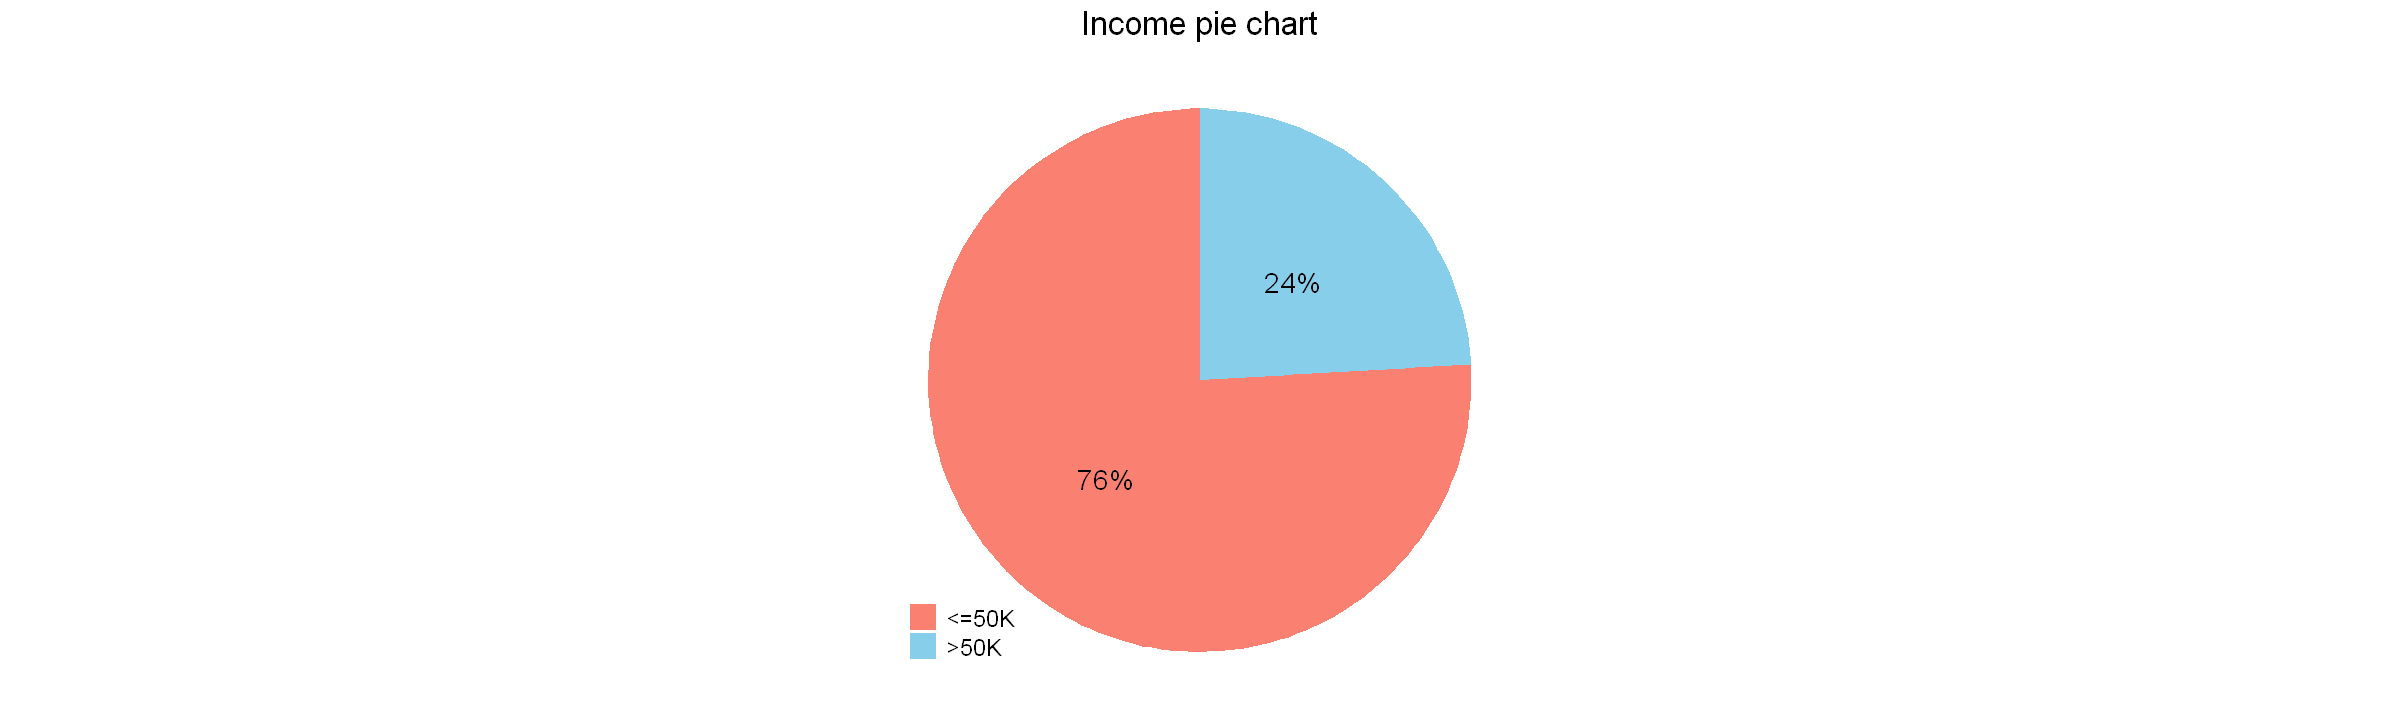

In [91]:
options(repr.plot.width=20, repr.plot.height=6)
ggplot(adult_data, aes(x="", fill=income)) +
    geom_bar(width=1) +
    coord_polar('y') +
    labs(title='Income pie chart', fill="") +
    theme_void() +
    scale_fill_manual(values = c("<=50K" = "salmon", ">50K" = "skyblue")) +
    geom_text(aes(label = paste0(round((..count..)/sum(..count..)*100), "%")),
              stat = "count", position = position_stack(vjust = 0.5), size = 6) +
    theme(legend.position = c(0.15, 0.15),
          plot.title = element_text(hjust = 0.5, size=20),
          legend.text = element_text(size = 14))

#### Barplots

In [92]:
income_barplots <- lapply(head(factor_columns, -2), function(column) {
  ggplot(adult_data, aes_string(x = column, group = adult_data$income, fill = adult_data$income)) +
    geom_bar(position = 'dodge', aes(y = ..prop..)) +
    labs(title = paste("Income by", column), fill = "") +
    scale_y_continuous(breaks = seq(0, 1, by = 0.1), name = 'percentage') +
    scale_fill_manual(values = c("salmon", "skyblue")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
          axis.text.y = element_text(size = 14),
          axis.title.x = element_text(size = 14),
          axis.title.y = element_text(size = 14),
          plot.title = element_text(hjust = 0.5, size = 20),
          legend.text = element_text(size = 14),
          legend.position="none")
})

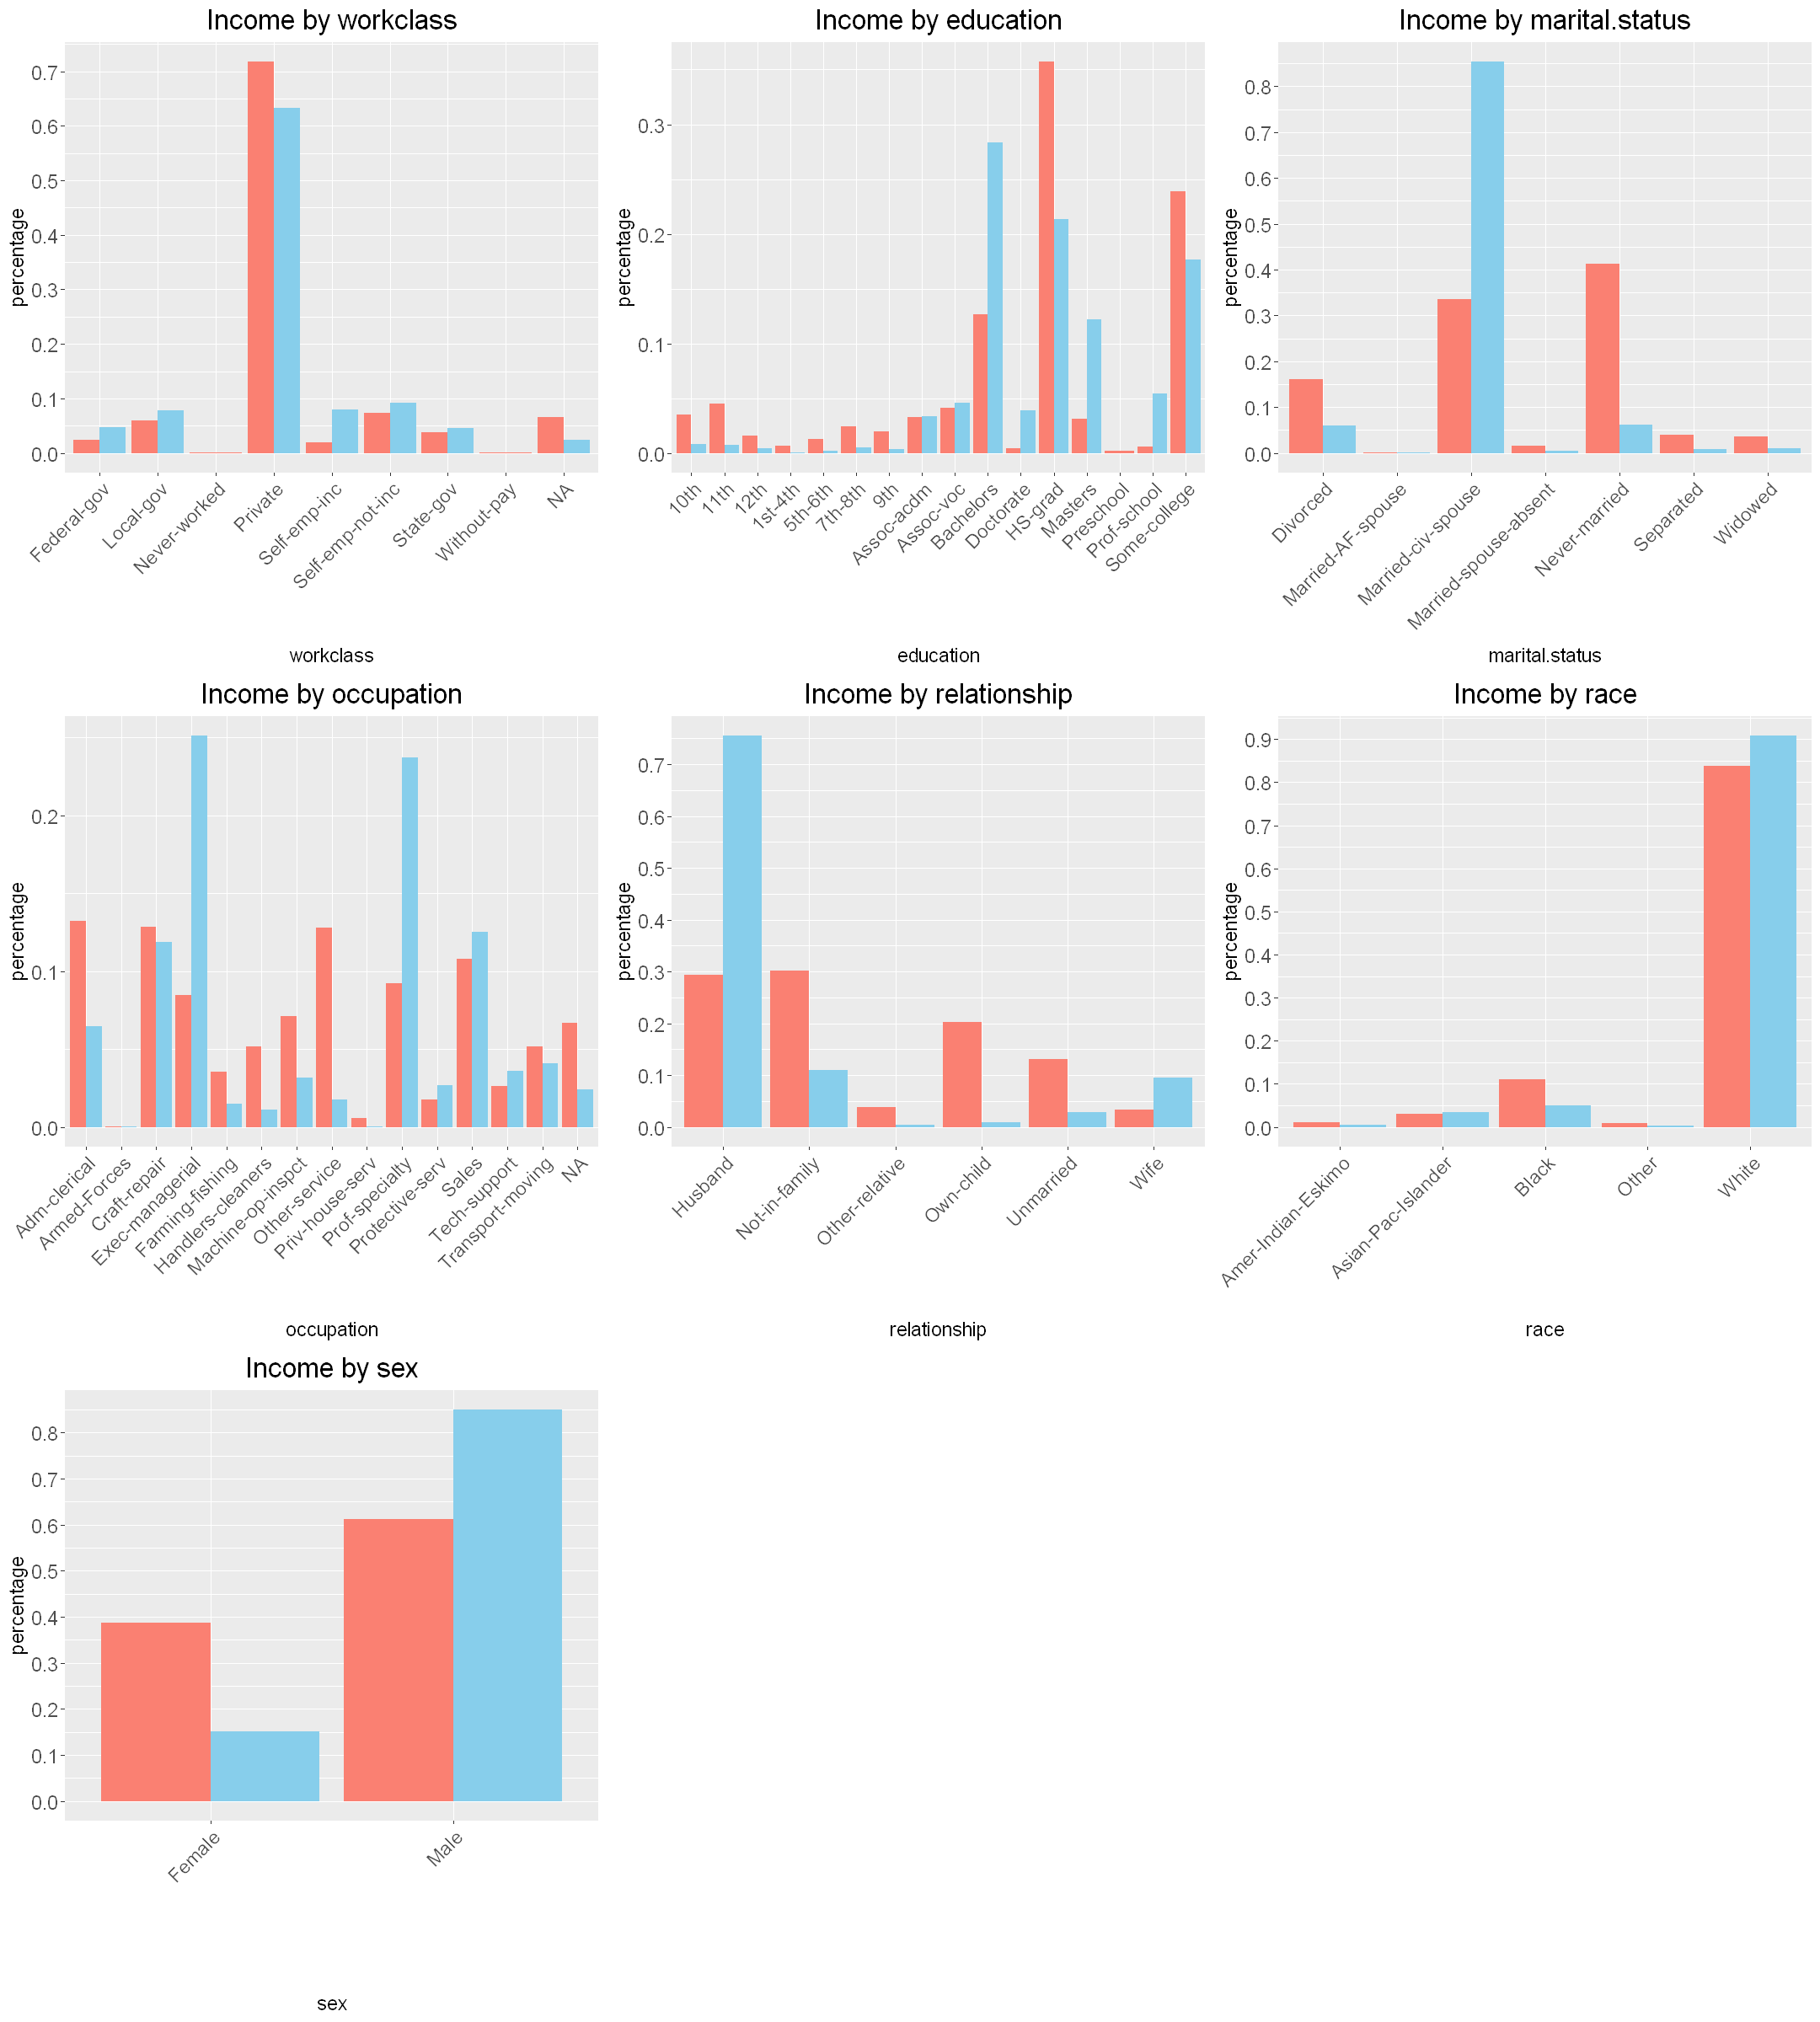

In [93]:
options(repr.plot.width=18, repr.plot.height=20)
plot_grid(plotlist = income_barplots, ncol = 3, align = "h")

In [94]:
income_density_by_age <- ggplot(adult_data, aes(x = age, fill = income, color=income)) +
                          geom_density(size=1, alpha=0.9) +
                          labs(title = "Density of Income by Age", x = "Age", y = "Density", fill = "Income", color='Income') +
                          scale_fill_manual(values = c("salmon", "skyblue")) +
                          scale_color_manual(values = c("#9C5048", "#476E7D"), guide = FALSE) +
                          scale_x_continuous(breaks = seq(0, 90, by = 10)) +
                          theme(axis.text.x = element_text(size = 14),
                              axis.text.y = element_text(size = 14),
                              axis.title.x = element_text(size = 14),
                              axis.title.y = element_text(size = 14),
                              plot.title = element_text(hjust = 0.5, size = 20),
                              legend.text = element_text(size = 14),
                              legend.position="none")
income_density_by_hours <- ggplot(adult_data, aes(x = hours.per.week, fill = income, color=income)) +
                          geom_density(size=1, alpha=0.9) +
                          labs(title = "Density of Income by Hours per week", x = "Hours per week", y = "Density", fill = "Income", color='Income') +
                          scale_fill_manual(values = c("salmon", "skyblue")) +
                          scale_color_manual(values = c("#9C5048", "#476E7D"), guide = FALSE) +
                          theme(axis.text.x = element_text(size = 14),
                              axis.text.y = element_text(size = 14),
                              axis.title.x = element_text(size = 14),
                              axis.title.y = element_text(size = 14),
                              plot.title = element_text(hjust = 0.5, size = 20),
                              legend.text = element_text(size = 14),
                              legend.position="none")

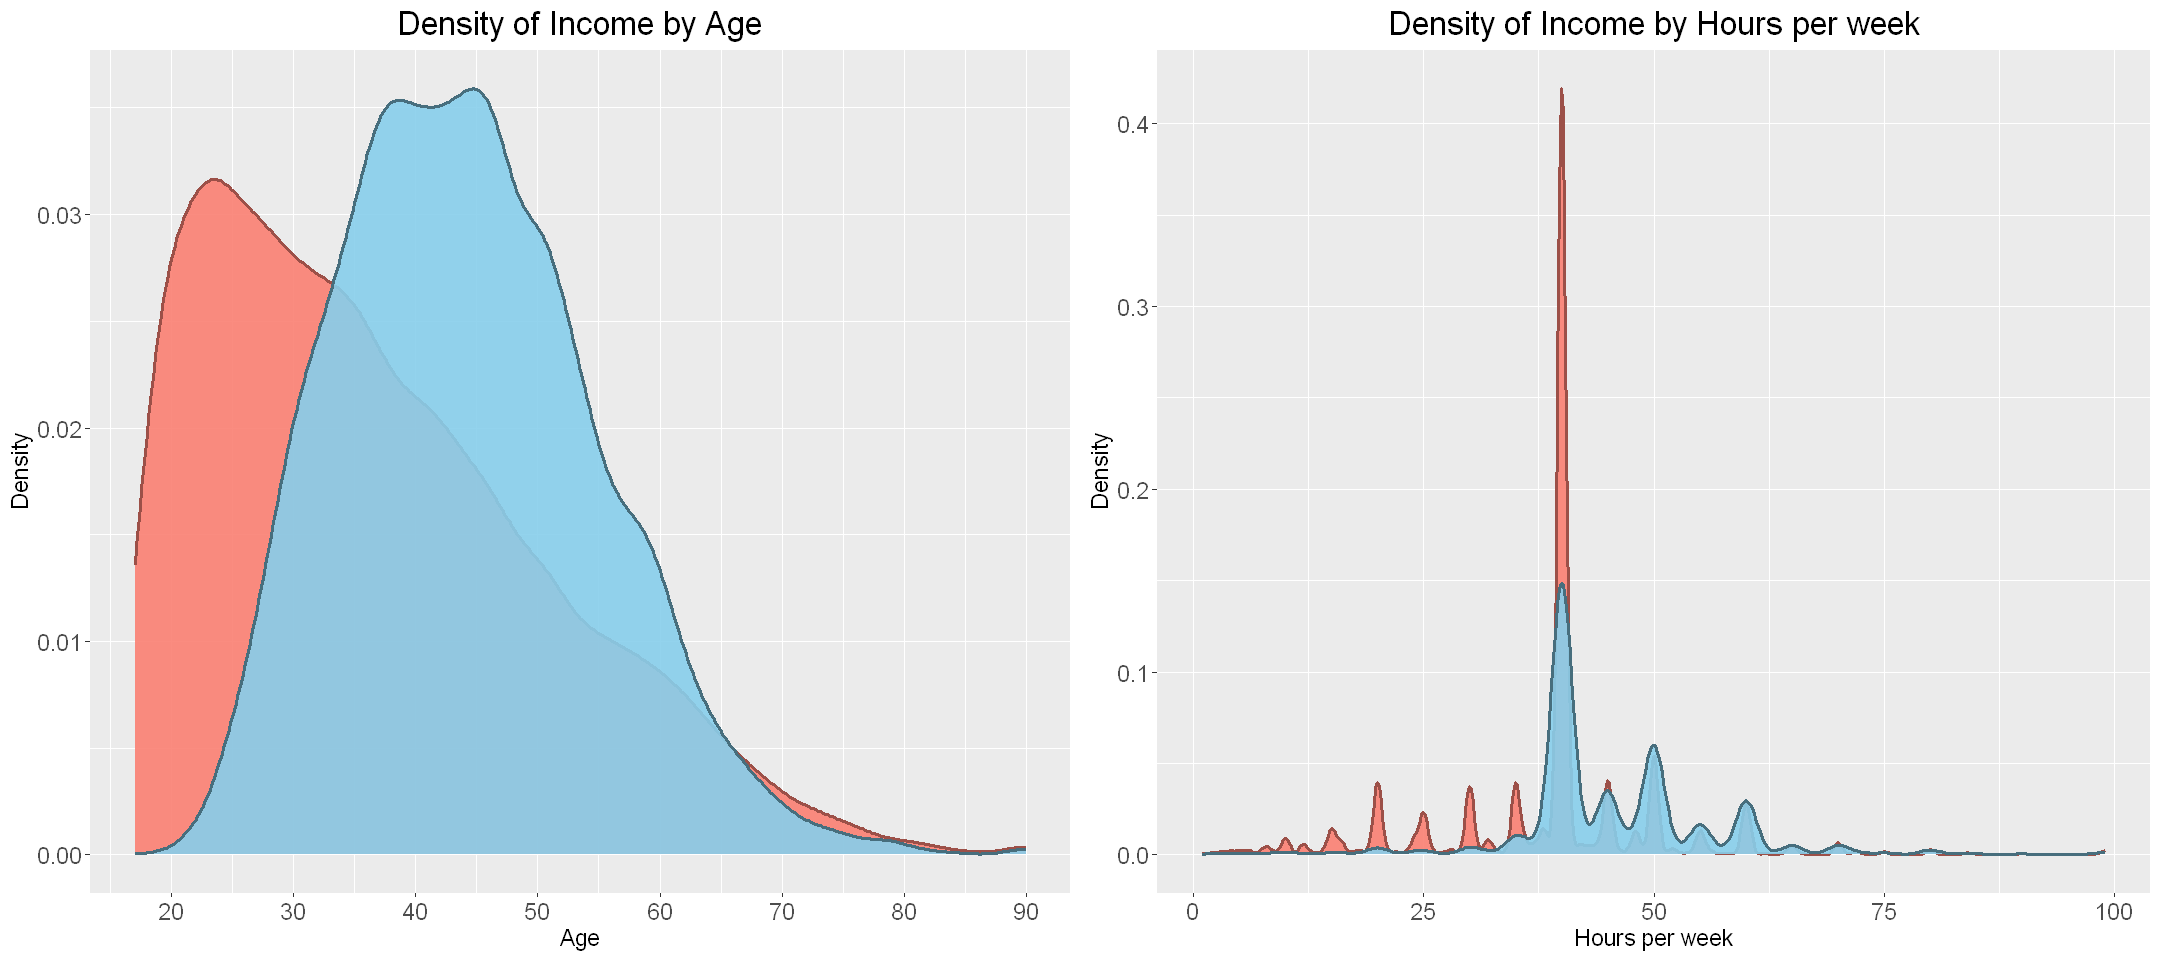

In [95]:
options(repr.plot.width=18, repr.plot.height=8)
plot_grid(income_density_by_age, income_density_by_hours, ncol = 2, align = "h")